# 10/03/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/100223_jam_results_milestone_anis_studies.ipynb
# 10/04/23 - Fixed lambda_int bounds and set correct object names for input, setting lower bound for const anisotropy from q_min lower bound
## Visualizing the 10/03/23 models.
## These models were done with Chin Yi's lens models, an additional bound on slow rotators q_min > 0.6, and lambda_int < 1.25 instead of 1.5 [ACTUALLY IT'S STILL 1.5]
#### 10/02/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/092523_jam_results_ttmc_meeting_prep.ipynb
##### Visualizing the 10/02/23 models.
#### 09/25/23 - Copied from 092123_jam_results_milestone_anis_studies.ipynb
##### Preparing some figures for my meeting with Michele and Tommaso.
#### 09/21/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/091323_jam_results_milestone_anis_studies.ipynb
##### I added the table "jam_model_dates.csv' to keep track of which dates to pull the models from.
##### This is so I use the correct model version when I redo subsets of models.
##### I am currently redoing J1250-(onward) with constant spherical because the 2023_09_15 models had the wrong bounds for the anisotropy parameter [0,1] when it should be [0,2].
#### 09/12/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/090723_jam_results_milestone_anis_studies.ipynb
##### Resultes from 091123_jam_milestone_anisotropy_studies.ipynb
##### 09/07/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/060923_jam_results_plotting_J1204.ipynb
##### Results from 090623_jam_milestone_anisotropy_studies.ipynb
##### 06/11/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/060623_jam_5obj_results_plotting.ipynb
##### Visualizing the results of first look into constraints on lambda_int with J1204.

In [1]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
import glob
from pathlib import Path
import pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import astropy.units as u
import astropy.constants as constants

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.jam_sph_proj import jam_sph_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
#from plotbin.sauron_colormap import register_sauron_colormap
#register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa
#from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_radial_mass import mge_radial_mass
from plotbin.symmetrize_velfield import symmetrize_velfield

# adamet
#from adamet.adamet import adamet
from adamet.corner_plot import corner_plot
# emcee
import emcee
import corner
from IPython.display import display, Math

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
#from slacs_ani_mass_jam import osipkov_merritt_model
#from slacs_ani_mass_jam import osipkov_merritt_generalized_model
#from slacs_ani_mass_jam import inner_outer_anisotropy_model
#from slacs_ani_mass_jam import nfw_generalized_model
#from slacs_ani_mass_jam import dark_halo_mge
#from slacs_ani_mass_jam import total_mass_mge
#from slacs_ani_mass_jam import jam_lnprob
#from slacs_ani_mass_jam import jam_lnprob_power_law
#from slacs_ani_mass_jam import jam_lnprob_nfw_constbeta
#from slacs_ani_mass_jam import jam_lnprob_nfwgen_constbeta
#from slacs_ani_mass_jam import jam_lnprob_nfw_om
#from slacs_ani_mass_jam import jam_lnprob_nfwgen_om
#from slacs_ani_mass_jam import summary_plot
#from slacs_ani_mass_jam import save_fit_parameters
#from slacs_ani_mass_jam import get_power_law_slope
#from slacs_ani_mass_jam import jampy_details
#from slacs_ani_mass_jam import prepare_to_jam
#from slacs_ani_mass_jam import space_jam
#from slacs_mge_jampy import make_gaussian

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
#extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
#photometric_zeropoint = 25.745
# redshift, convert to angular diameter dist in Mpc
#z = 0.195
#distance = cosmo.angular_diameter_distance(z).value

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


In [2]:
##################################################################################################################################

date_of_kin = '2023-02-28_2'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
print(f'Outputs will be in {jam_output_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_051223.csv')
zs = paper_table['zlens']

Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/



In [3]:
active_obj_names = obj_names.copy() # np.array(obj_names)[active_obj]
active_obj_names.remove(obj_names[2])
active_obj_names.remove('SDSSJ1538+5817')
active_obj_names.remove('SDSSJ1630+4520')
active_obj_names.remove('SDSSJ2303+1422')
active_obj_names

['SDSSJ0029-0055',
 'SDSSJ0037-0942',
 'SDSSJ1112+0826',
 'SDSSJ1204+0358',
 'SDSSJ1250+0523',
 'SDSSJ1306+0600',
 'SDSSJ1402+6321',
 'SDSSJ1531-0105',
 'SDSSJ1621+3931',
 'SDSSJ1627-0053']

______________________

# Dynamical Modeling with JAM


In [4]:
# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapsf 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=dVrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff

########################################################################


def prepare_to_jam(obj_name, file_dir, SN):

    # take the surface density, etc from mge saved parameters
    with open(f'{file_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)
        
    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    #kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst # mistake in name  
    try:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
    except:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst
    Vrms_bin = tommy_pickles.Vrms_bin
    dVrms_bin = tommy_pickles.dVrms_bin 
    #dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    return (surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)


########################################################################


# functions to view previous samplings

def get_best_param_err (obj_name, SN, model, anisotropy, align, model_dir=None, date_time=None, run_id=None):

    '''
    obj_name and number steps to try it out. Start all with the same priors.
    '''

    obj_abbr = obj_name[4:9] # e.g. J0029
    #zlens = zlens[i]
    #distance = cosmo.angular_diameter_distance(zlens).value

    #mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
    kin_dir = f'{kinematics_dir}{obj_name}/'
    #jam_dir = f'{jam_output_dir}{obj_name}/'
    
    if obj_abbr=='J0330':
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    
    # Get model directory
    if model_dir is not None:
        model_dir = f'{model_dir}/'
    elif date_time is not None and run_id is None:
        target_jam_dir = f'{jam_dir}target_sn_{SN}/'
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{SN}_{model}_{anisotropy}_{align}/'
    elif date_time is None:
        target_jam_dir = f'{jam_dir}target_sn_{SN}/'
        date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{SN}_{model}_{anisotropy}_{align}/'
    elif date_time is not None and run_id is not None:
        target_jam_dir = f'{jam_dir}target_sn_{SN}/'
        model_dir =  f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{SN}_{model}_{anisotropy}_{align}/'   
    else:
        print('something wrong')
    
    #
    bestfit = np.genfromtxt(glob.glob(f'{model_dir}*_bestfit_parameters.txt')[0], delimiter='')
    err = np.genfromtxt(glob.glob(f'{model_dir}*_bestfit_parameters_error.txt')[0], delimiter='')
    pars = np.genfromtxt(glob.glob(f'{model_dir}*_parameters_fit.txt')[0], delimiter='')
    lnprob = np.genfromtxt(glob.glob(f'{model_dir}*_likelihood.txt')[0], delimiter='') 
    bounds = np.genfromtxt(glob.glob(f'{model_dir}*_bounds.txt')[0], delimiter='')
    rms_model = np.genfromtxt(glob.glob(f'{model_dir}*_rms_model.txt')[0], delimiter='')
    flux_model = np.genfromtxt(glob.glob(f'{model_dir}*_flux_model.txt')[0], delimiter='')
    #print(labels)
    #print(glob.glob(f'{model_dir}*_kwargs.pkl'))
    with open(glob.glob(f'{model_dir}*_kwargs.pkl')[0], "rb") as f:
        kwargs = pickle.load(f)
        f.close()
    
    lnprob_best, chi2_best = jam_lnprob_chi2(bestfit, **kwargs)  # Compute chi2 of model at best fit location
    
    return bestfit, err, pars, lnprob, lnprob_best, chi2_best, bounds, rms_model, flux_model, kwargs#, labels
    
# weighted gaussian to compare the models..
def weighted_gaussian(xx, mu, sig, c2):
    yy = np.zeros(shape=xx.shape)
    for i in range(len(xx)):
        yy[i] = np.exp(-np.power(xx[i] - mu, 2.) / (2 * np.power(sig, 2.))) * np.exp(-0.5 * c2)
    return yy


def get_labels(model, anisotropy):
    if model=='power_law':
        if anisotropy=='const':              
            labels = [r'$\gamma$', r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$\theta_E$"]
        elif anisotropy=='OM':
            labels = [r'$\gamma$', r"$q_{\rm min}$", r"$a_{ani}$", r"$\theta_E$"]
    elif model=='nfw':
        if anisotropy=='const':
            labels = [r"$f_{\rm DM}$", r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$\lg(M_\ast/L)$"]
        elif anisotropy=='OM':     
            labels = [r"$f_{\rm DM}$", r"$q_{\rm min}$", r"$a_{ani}$", r"$\lg(M_\ast/L)$"]
    return labels


########################################################################


def summary_plot(obj_name, date_time, model_dir, jam_prob_func, model_name, \
                     pars=None, lnprob=None, labels=None, bounds=None, \
                     kwargs=None, save=False, load=False):
    
    """
    Print the best fitting solution with uncertainties.
    Plot the final corner plot with the best fitting JAM model.

    """
    
    xbin = kwargs['xbin']
    ybin = kwargs['ybin']
    goodbins = kwargs['goodbins']
    rms = kwargs['rms']
    erms = kwargs['erms']
    reff = kwargs['reff']
    
    if load == True:
        jam_test_dir = model_dir #f'{data_dir}jam_testing/2023_01_31/'
        pars = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*parameters_fit.txt')[0])
        lnprob = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*likelihood.txt')[0])
        labels = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*labels.txt')[0], delimiter='  ', dtype='<U20')
        bounds = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bounds.txt')[0])
        bestfit = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters.txt')[0])
        perc = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters_percentile.txt')[0])
        sig_bestfit = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters_error.txt')[0])
        surf_potential = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*surf_potential.txt')[0])
        rms_model = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*rms_model.txt')[0])
        flux_model = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*flux_model.txt')[0])
    
    else:
        
        bestfit = pars[np.argmax(lnprob)]  # Best fitting parameters
        perc = np.percentile(pars, [15.86, 84.14], axis=0)  # 68% interval
        sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)
        
        # save variables, surf_pot, sigma_pot, qobs_pot, rms_model and flux_model
        
        # jam the best fit
        jam, surf_potential = jam_bestfit(bestfit, **kwargs)
        rms_model = jam.model
        flux_model = jam.flux

    print("\nBest-fitting parameters and 1sigma errors:")
    for label, best, sig in zip(labels, bestfit, sig_bestfit):
        print(f"   {label} = {best:#.4g} +/- {sig:#.2g}")

    # For plotting, only show the finite probability points
    finite = np.isfinite(lnprob)

    # Produce final corner plot without trial values and with best fitting JAM
    plt.rcParams.update({'font.size': 14})
    plt.clf()
    corner_plot(pars[finite], lnprob[finite], labels=labels, extents=bounds, fignum=1)
    logprob = jam_prob_func(bestfit, **kwargs)  # Compute model at best fit location
    chi2 = np.nansum((rms_model-rms)**2/(erms)**2) # -2*logprob
                              
    dx = 0.24
    yfac = 0.87
    fig = plt.gcf()
    fig.set_size_inches((12,12))
    fig.tight_layout()
    
    i = 0                          
    # annotate the model results
    plt.annotate(f'chi2 = {np.around(chi2, 2)}', (0.30, 0.97-(1+len(labels))*0.03), xycoords='figure fraction', fontsize=16)
    for label, best, sig in zip(labels, bestfit, sig_bestfit):
        string = f"{label} = {best:#.4g} ± {sig:#.2g}"
        plt.annotate(string, (0.30, 0.94-i*0.03), xycoords='figure fraction', fontsize=16) 
        i = i+1
                                
    # plot circular reff
    reff_plot = plt.Circle((0,0), reff, color='k', fill=False, linestyle='--')
                                 
    # plot data
    fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    rms1 = rms.copy()
    rms1[goodbins] = symmetrize_velfield(xbin[goodbins], ybin[goodbins], rms[goodbins])
    vmin, vmax = np.percentile(rms1[goodbins], [0.5, 99.5])
    plot_velfield(xbin, ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    plt.tick_params(labelbottom=False)
    plt.ylabel('arcsec')
    ax = plt.gca()
    ax.add_patch(reff_plot)
                              
    # plot circular reff again... can only patch one time
    reff_plot = plt.Circle((0,0), reff, color='k', fill=False, linestyle='--')
    
    # plot model
    fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    plot_velfield(xbin, ybin, rms_model, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    #plt.tick_params(labelbottom=False)
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    ax = plt.gca()
    ax.add_patch(reff_plot)
                              
    if save==True:
        plt.savefig(f'{model_dir}{obj_name}_corner_plot_{model_name}_{date_time}.png', bbox_inches='tight')
        plt.savefig(f'{model_dir}{obj_name}_corner_plot_{model_name}_{date_time}.pdf', bbox_inches='tight')

    plt.pause(1)
    plt.clf()
    plt.close()
                            
                                                                
        
    return surf_potential, rms_model, flux_model, bestfit, perc, sig_bestfit, chi2



########################################################################


def jam_lnprior (pars, bounds, mu, sigma, prior_type):
    '''
    Calculate the prior likelihood for the sampled parameters
    pars
    mu - mean of prior
    sigma - width of prior
    prior_type - uniform, gaussian, log_uniform, log_normal
    '''
    
    pars = np.array(pars)
    mu = np.array(mu)
    sigma = np.array(sigma)

    if any(pars < bounds[0]) or any(pars > bounds[1]):
        lnprior = -np.inf
    
    else:
        lnprior=np.ones_like(pars)
        for i in range(len(pars)):
            if prior_type[i]=='uniform':
                lnprior[i]=0.
            elif prior_type[i]=='gaussian':
                lnprior[i]=np.log(1.0/(np.sqrt(2*np.pi)*sigma[i]))-0.5*(pars[i]-mu[i])**2/sigma[i]**2
            
    return np.sum(lnprior)


########################################################################


# set up new anisotropy functions and probability functions to be fit

def jam_lnprob (pars, bounds=None, p0=None, sigpar=None, prior_type=None,
                surf_lum=None, sigma_lum=None, qobs_lum=None, distance=None,
                  xbin=None, ybin=None, sigmapsf=None, normpsf=None, goodbins=None,
                   rms=None, erms=None, pixsize=None, reff=None, plot=True, 
                 model=None, anisotropy=None, geometry=None, align=None, 
                labels=None, zlens=None, zsource=None, rs_mst=None):
    
    """
    Return the probability of the model, given the data, assuming constant priors

    """
    
    lnprior = jam_lnprior (pars, bounds, mu=p0, sigma=sigpar, prior_type=prior_type)
    
    if np.isinf(lnprior) or np.isnan(lnprior):
        return -np.inf
    
    else:
        # axisymmetric model takes jam_axi_proj
        if geometry == 'axi':
            # parameters for fitting
            # Mass model
            if model=='power_law':
                gamma, q, anis_param, theta_E, lambda_int = pars
                # let f_dm = 0 for a power law
                f_dm = 0
            elif model=='nfw':
                f_dm, q, anis_param, lg_ml, lambda_int = pars
                # gamma = -1 for NFW
                gamma = -1
            # Anisotropy is dependent on model
            if anisotropy=='const':
                logistic=False
                ratio = anis_param
                beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
                # lower bound is constrained by q as R(q) = sqrt(0.3 + 0.7*q) # where q in this case is the q_min I'm fitting
                # This is a constraint from intrinsic shape
                R_q = np.sqrt(0.3 + 0.7*q)
                if ratio < R_q:
                    anisotropy_constraint = 0
                else:
                    anisotropy_constraint = 1
            elif anisotropy=='OM':
                logistic=True
                a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
                r_a = a_ani*reff
                beta_0 = 0 # fully isotropic
                beta_inf = 1 # fully radially anisotropic
                alpha = 2 # sharpness of transition
                beta = np.array([r_a, beta_0, beta_inf, alpha])
                anisotropy_constraint = 1 # doesn't apply here
            # Continue if good to go
            if anisotropy_constraint == 1: # i.e. the constraint from q

                # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
                qmin = np.min(qobs_lum)
                inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))

                # Obtain total mass profile
                surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                               reff, model, zlens, zsource,
                                                              gamma, f_dm, inc, theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                               plot=plot)
                # ignore central black hole
                mbh=0.
                # make the JAM model
                jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                                   inc, mbh, distance, xbin, ybin, 
                                    align=align, beta=beta, logistic=logistic,
                                   data=rms, errors=erms, goodbins=goodbins,
                                   pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
                                   plot=plot,  quiet=1, ml=1, nodots=True)

                resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
                chi2 = resid @ resid
                lnprob = -0.5*chi2 + lnprior
            else:
                lnprob = -np.inf # reject this one
        
        # sph geometry is a different jam function
        elif geometry == 'sph':
            # parameters for fitting
            # Mass model
            if model=='power_law':
                gamma, anis_param, theta_E, lambda_int = pars
                # let f_dm = 0 for a power law
                f_dm = 0
            elif model=='nfw':
                f_dm, anis_param, lg_ml, lambda_int = pars
                # gamma = -1 for NFW
                gamma = -1
            # Anisotropy is dependent on model
            if anisotropy=='const':
                logistic=False
                ratio = anis_param
                beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
                rani = None
            elif anisotropy=='OM':
                logistic=True
                a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
                r_a = a_ani*reff
                # put in r_ani keyword
                beta_0 = 0 # fully isotropic
                beta_inf = 1 # fully radially anisotropic
                alpha = 2 # sharpness of transition
                beta = np.array([r_a, beta_0, beta_inf, alpha])
            # Obtain total mass profile
            surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                           reff, model, zlens, zsource,
                                                          gamma, f_dm, inc=90, theta_E=theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                           plot=plot)
            # get radius of bin centers
            #rad_bin = np.sqrt(xbin**2 + ybin**2)
            # ignore central black hole
            mbh=0.
            # There is no "goodbins" keyword for jam_sph_proj, so I need to adjust the data as such
            #rms = rms[goodbins]
            #erms = erms[goodbins]
            #rad_bin = rad_bin[goodbins]

            # Now run the jam model
            #jam = jam_sph_proj(surf_lum, sigma_lum, surf_pot, sigma_pot, 
            #                   mbh, distance, rad_bin, #xbin, ybin, align=align, 
            #                    beta=beta, logistic=logistic, rani=r_a,
            #                   data=rms, errors=erms, #goodbins=goodbins, # there is no goodbins
            #                   pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
            #                   plot=plot, quiet=1, ml=1)#, nodots=True) # there is no nodots
            ####### 10/02/23 - for now, we will run jam_axi_proj, which is the same as jam_sph_proj in the spherical limit that q=1
            inc=90
            jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                               inc, mbh, distance, xbin, ybin, 
                                align=align, beta=beta, logistic=logistic,
                               data=rms, errors=erms, goodbins=goodbins,
                               pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
                               plot=plot,  quiet=1, ml=1, nodots=True)
            resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
            chi2 = resid @ resid
            lnprob = -0.5*chi2 + lnprior

        return lnprob




########################################################################

# set up new anisotropy functions and probability functions to be fit

def jam_lnprob_chi2 (pars, bounds=None, p0=None, sigpar=None, prior_type=None,
                surf_lum=None, sigma_lum=None, qobs_lum=None, distance=None,
                  xbin=None, ybin=None, sigmapsf=None, normpsf=None, goodbins=None,
                   rms=None, erms=None, pixsize=None, reff=None, plot=True, 
                 model=None, anisotropy=None, geometry=None, align=None, 
                labels=None, zlens=None, zsource=None, rs_mst=None):
    
    """
    Return the probability and chi2 of the model, given the data, assuming constant priors

    """
    
    lnprior = jam_lnprior (pars, bounds, mu=p0, sigma=sigpar, prior_type=prior_type)
    
    if np.isinf(lnprior) or np.isnan(lnprior):
        return -np.inf, np.inf
    
    else:
        # axisymmetric model takes jam_axi_proj
        if geometry == 'axi':
            # parameters for fitting
            # Mass model
            if model=='power_law':
                gamma, q, anis_param, theta_E, lambda_int = pars
                # let f_dm = 0 for a power law
                f_dm = 0
            elif model=='nfw':
                f_dm, q, anis_param, lg_ml, lambda_int = pars
                # gamma = -1 for NFW
                gamma = -1
            # Anisotropy is dependent on model
            if anisotropy=='const':
                logistic=False
                ratio = anis_param
                beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
                # lower bound is constrained by q as R(q) = sqrt(0.3 + 0.7*q) # where q in this case is the q_min I'm fitting
                # This is a constraint from intrinsic shape
                R_q = np.sqrt(0.3 + 0.7*q)
                if ratio < R_q:
                    anisotropy_constraint = 0
                else:
                    anisotropy_constraint = 1
            elif anisotropy=='OM':
                logistic=True
                a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
                r_a = a_ani*reff
                beta_0 = 0 # fully isotropic
                beta_inf = 1 # fully radially anisotropic
                alpha = 2 # sharpness of transition
                beta = np.array([r_a, beta_0, beta_inf, alpha])
                anisotropy_constraint = 1 # doesn't apply here
            # Continue if good to go
            if anisotropy_constraint == 1: # i.e. the constraint from q

                # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
                qmin = np.min(qobs_lum)
                inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))

                # Obtain total mass profile
                surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                               reff, model, zlens, zsource,
                                                              gamma, f_dm, inc, theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                               plot=plot)
                # ignore central black hole
                mbh=0.
                # make the JAM model
                jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                                   inc, mbh, distance, xbin, ybin, 
                                    align=align, beta=beta, logistic=logistic,
                                   data=rms, errors=erms, goodbins=goodbins,
                                   pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
                                   plot=plot,  quiet=1, ml=1, nodots=True)

                resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
                chi2 = resid @ resid
                lnprob = -0.5*chi2 + lnprior
            else:
                lnprob = -np.inf # reject this one
                chi2 = np.inf            
        
        # sph geometry is a different jam function
        elif geometry == 'sph':
            # parameters for fitting
            # Mass model
            if model=='power_law':
                gamma, anis_param, theta_E, lambda_int = pars
                # let f_dm = 0 for a power law
                f_dm = 0
            elif model=='nfw':
                f_dm, anis_param, lg_ml, lambda_int = pars
                # gamma = -1 for NFW
                gamma = -1
            # Anisotropy is dependent on model
            if anisotropy=='const':
                logistic=False
                ratio = anis_param
                beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
                rani = None
            elif anisotropy=='OM':
                logistic=True
                a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
                r_a = a_ani*reff
                # put in r_ani keyword
                beta_0 = 0 # fully isotropic
                beta_inf = 1 # fully radially anisotropic
                alpha = 2 # sharpness of transition
                beta = np.array([r_a, beta_0, beta_inf, alpha])
            # Obtain total mass profile
            surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                           reff, model, zlens, zsource,
                                                          gamma, f_dm, inc=90, theta_E=theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                           plot=plot)
            # get radius of bin centers
            #rad_bin = np.sqrt(xbin**2 + ybin**2)
            # ignore central black hole
            mbh=0.
            # There is no "goodbins" keyword for jam_sph_proj, so I need to adjust the data as such
            #rms = rms[goodbins]
            #erms = erms[goodbins]
            #rad_bin = rad_bin[goodbins]

            # Now run the jam model
            #jam = jam_sph_proj(surf_lum, sigma_lum, surf_pot, sigma_pot, 
            #                   mbh, distance, rad_bin, #xbin, ybin, align=align, 
            #                    beta=beta, logistic=logistic, rani=r_a,
            #                   data=rms, errors=erms, #goodbins=goodbins, # there is no goodbins
            #                   pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
            #                   plot=plot, quiet=1, ml=1)#, nodots=True) # there is no nodots
            ####### 10/02/23 - for now, we will run jam_axi_proj, which is the same as jam_sph_proj in the spherical limit that q=1
            inc=90
            jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                               inc, mbh, distance, xbin, ybin, 
                                align=align, beta=beta, logistic=logistic,
                               data=rms, errors=erms, goodbins=goodbins,
                               pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
                               plot=plot,  quiet=1, ml=1, nodots=True)
            resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
            chi2 = resid @ resid
            lnprob = -0.5*chi2 + lnprior

            
    return lnprob, chi2


########################################################################

def jam_bestfit (pars, **kwargs):
    
    """
    Return the model of the bestfit parameters

    """
    
    surf_lum=kwargs['surf_lum']
    sigma_lum=kwargs['sigma_lum']
    qobs_lum=kwargs['qobs_lum']
    distance=kwargs['distance']
    xbin=kwargs['xbin']
    ybin=kwargs['ybin']
    sigmapsf=kwargs['sigmapsf']
    normpsf=kwargs['normpsf']
    goodbins=kwargs['goodbins']
    rms=kwargs['rms']
    erms=kwargs['erms']
    pixsize=kwargs['pixsize']
    reff=kwargs['reff']
    plot=kwargs['plot']
    model=kwargs['model']
    anisotropy=kwargs['anisotropy']
    geometry=kwargs['geometry']
    align=kwargs['align']
    zlens=kwargs['zlens']
    zsource=kwargs['zsource']
    rs_mst=kwargs['rs_mst']
    
    print(model)
    
    
    ##### axisymmetric geometry
    if geometry=='axi':
        # parameters for fitting
        # Mass model
        if model=='power_law':
            gamma, q, anis_param, theta_E, lambda_int = pars
            # let f_dm = 0 for a power law
            f_dm = 0
        elif model=='nfw':
            f_dm, q, anis_param, theta_E, lambda_int = pars
            # gamma = -1 for NFW
            gamma = -1

        # Anisotropy is dependent on model
        if anisotropy=='const':
            logistic=False
            ratio = anis_param
            beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
        elif anisotropy=='OM':
            logistic=True
            a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
            r_a = a_ani*reff
            beta_0 = 0 # fully isotropic
            beta_inf = 1 # fully radially anisotropic
            alpha = 2 # sharpness of transition
            beta = [r_a, beta_0, beta_inf, alpha]

        # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
        qmin = np.min(qobs_lum)
        inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
        # Check if this is the same for prolate... See Capp 2002

        # Obtain total mass profile
        surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                       reff, model, zlens, zsource,
                                                      gamma, f_dm, inc, theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                       plot=plot)

        surf_potential = np.stack((surf_pot, sigma_pot, qobs_pot))

        # ignore central black hole
        mbh=0.

        print('JAMMING the best fit model')

        # make the JAM model
        jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                           inc, mbh, distance, xbin, ybin, pixsize=pixsize,
                           sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align=align,
                           beta=beta, logistic=logistic, data=rms, errors=erms, 
                           ml=1, plot=True, quiet=1, nodots=True)
        
    #### spherical geometry
    elif geometry=='sph':
            # parameters for fitting
        # Mass model
        if model=='power_law':
            gamma, anis_param, theta_E, lambda_int = pars
            # let f_dm = 0 for a power law
            f_dm = 0
        elif model=='nfw':
            f_dm, anis_param, theta_E, lambda_int = pars
            # gamma = -1 for NFW
            gamma = -1

        # Anisotropy is dependent on model
        if anisotropy=='const':
            logistic=False
            ratio = anis_param
            beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
        elif anisotropy=='OM':
            logistic=True
            a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
            r_a = a_ani*reff
            beta_0 = 0 # fully isotropic
            beta_inf = 1 # fully radially anisotropic
            alpha = 2 # sharpness of transition
            beta = [r_a, beta_0, beta_inf, alpha]


        # Obtain total mass profile
        surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                       reff, model, zlens, zsource,
                                                      gamma, f_dm, inc=90, theta_E=theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                       plot=plot)

        surf_potential = np.stack((surf_pot, sigma_pot, qobs_pot))

        # get radius of bin centers
        #rad_bin = np.sqrt(xbin**2 + ybin**2)
        # ignore central black hole
        mbh=0.

        print('JAMMING the best fit model')
        
        # There is no "goodbins" keyword for jam_axi_sph, so I need to adjust the data as such
        #rms = rms[goodbins]
        #erms = erms[goodbins]
        #rad_bin = rad_bin[goodbins]
        # Now run the jam model

        # make the JAM model
        #jam = jam_sph_proj(surf_lum, sigma_lum, surf_pot, sigma_pot, 
        #                   mbh, distance, rad_bin, #xbin, ybin, align=align, 
        #                    beta=beta, logistic=logistic, rani=r_a,
        #                   data=rms, errors=erms, #goodbins=goodbins,
        #                   pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
        #                   plot=plot, quiet=1, ml=1)#, nodots=True)
        ####### 10/02/23 - for now, we will run jam_axi_proj, which is the same as jam_sph_proj in the spherical limit that q=1
        inc=90
        jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                           inc, mbh, distance, xbin, ybin, 
                            align=align, beta=beta, logistic=logistic,
                           data=rms, errors=erms, goodbins=goodbins,
                           pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
                           plot=plot,  quiet=1, ml=1, nodots=True)

    return jam, surf_potential


###############################################################################

def power_law_mge (gamma, theta_E, q, rbreak, lambda_int, rs_mst, zlens, zsource, plot=False):
    """
    gamma - power law slope (2 = isothermal)
    theta_E - einstein radius
    q - mean q from gaussian components of light profile
    rbreak - some radius... make it big?
    lamdba_int - MST parameter
    zlens/source - redshjifts
    """
    # The fit is performed in log spaced radii from 1" to 10*rbreak
    n = 1000     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    
    # Now working in convergence
    kappa = (3 - gamma) / 2 * (theta_E/r)**(gamma-1)
    #surf_mass_dens = (3 - gamma) / 2 * (rbreak/r)**(gamma-1)
    
    # transform by lambda_int
    kappa_mst = mass_sheet_transform(kappa, lambda_int, rbreak, rs_mst, zlens, zsource)
    #surf_mass_dens_mst = mass_sheet_transform(surf_mass_dens, lambda_int, rbreak, zlens, zsource)
    
    # Go from convergence to surface mass density with critical surface density
    # get distances
    DL = cosmo.angular_diameter_distance(zlens).to('pc')
    DS = cosmo.angular_diameter_distance(zsource).to('pc')
    DLS = cosmo.angular_diameter_distance_z1z2(zlens, zsource).to('pc')
    # calculate critical surface density
    sigma_crit = c2_4piG * DS / DL / DLS
    # calculate surface mass density with sigma_crit
    surf_mass_dens = kappa_mst * sigma_crit.value
    
    m = mge_fit_1d(r, surf_mass_dens, ngauss=20, inner_slope=20, outer_slope=0, quiet=1, plot=plot) # this creates a circular gaussian with sigma=sigma_x (i.e. along the major axis)
    
    surf_pot, sigma_pot = m.sol           # total counts of gaussians
    surf_pot = surf_pot / np.sqrt(2*np.pi) / sigma_pot # THIS should give peak surface density
    qobs_pot = np.ones_like(surf_pot)*q   # Multiply by q to convert to elliptical Gaussians where sigma is along the major axis... I'm not sure if this is perfectly correct
    
    return surf_pot, sigma_pot, qobs_pot



###############################################################################

def dark_halo_mge (gamma, rbreak, lambda_int, zlens, zsource, plot=False):
    """
    Returns the MGE parameters for a generalized spherical NFW dark halo profile
    https://ui.adsabs.harvard.edu/abs/2001ApJ...555..504W
    Inputs:
        gamma - inner profile slope (logarithmic slope, i.e. slope when plotted as log(rho) to log(r), < 0
                if gamma = -1, this is standard NFW profile
        rbreak - break radius, transition from inner slope to outer slope (of -3)
    Outputs:
        surf_dm, sigma_dm, qobs_dm - MGE parameters of dark halo surface potential (peak surface density, sigma of Gaussians, and axial ratio (1 because it's spherical)
        
    """
    # The fit is performed in log spaced radii from 1" to 10*rbreak
    n = 1000     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    rho = nfw_generalized_model (r, gamma, rbreak)
    m = mge_fit_1d(r, rho, ngauss=15, inner_slope=20, outer_slope=0, quiet=1, plot=plot)

    surf_dm, sigma_dm = m.sol           # Peak surface density and sigma # 05/22/23 - I think this actually gives the "total counts", not peak surface density
    #surf_dm = surf_dm / np.sqrt(2*np.pi) / sigma_dm # THIS should give peak surface density
    ##### 06/08/23 - I was wrong. Because I am fitting the MGE to the volume density, dens = surf/(np.sqrt(2*np.pi)*Sigma)
    qobs_dm = np.ones_like(surf_dm)     # Assume spherical dark halo

    return surf_dm, sigma_dm, qobs_dm


########################################################################

def total_mass_mge (surf_lum, sigma_lum, qobs_lum, 
                    reff, model, zlens, zsource,
                    gamma, f_dm, inc, theta_E, lambda_int=1, rs_mst=0.5, lg_ml=None,
                     plot=False):
    
    """
    Combine the MGE from a dark halo and the MGE from the stellar surface
    brightness in such a way to have a given dark matter fractions f_dm
    inside a sphere of radius one half-light radius reff
    
    # 06/09/23 - I need to figure out how to scale with the Einstein radius instead of M/L
    """
    
    break_factor = 100 # factor by which reff is multiplied to set truncation of mass profile
    
    if model == 'nfw':
        
        gamma = -1
        rbreak = break_factor*reff # much bigger than data # should this be a free parameter?

        surf_dm, sigma_dm, qobs_dm = dark_halo_mge(gamma, rbreak, lambda_int, zlens, zsource, plot)
        #plt.pause(1)

        stars_lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
        dark_mass_re = mge_radial_mass(surf_dm, sigma_dm, qobs_dm, inc, reff)

        # Find the scale factor needed to satisfy the following definition
        # f_dm == dark_mass_re*scale/(stars_lum_re + dark_mass_re*scale)
        scale = (f_dm*stars_lum_re)/(dark_mass_re*(1 - f_dm))

        surf_pot = np.append(surf_lum, surf_dm*scale)   # Msun/pc**2. DM scaled so that f_DM(Re)=f_DM
        sigma_pot = np.append(sigma_lum, sigma_dm)      # Gaussian dispersion in arcsec
        qobs_pot = np.append(qobs_lum, qobs_dm)
        
        # Note: I multiply surf_pot by ml=10**lg_ml, while I set the keyword ml=1
        # Both the stellar and dark matter increase by ml and f_dm is unchanged
        surf_pot *= 10**lg_ml
        
        
        
    elif model == 'nfw_general':
        
        gamma = gamma
        rbreak = break_factor*reff # much bigger than data

        surf_dm, sigma_dm, qobs_dm = dark_halo_mge(gamma, rbreak, lambda_int, zlens, zsource, plot)

        stars_lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
        dark_mass_re = mge_radial_mass(surf_dm, sigma_dm, qobs_dm, inc, reff)

        # Find the scale factor needed to satisfy the following definition
        # f_dm == dark_mass_re*scale/(stars_lum_re + dark_mass_re*scale)
        scale = (f_dm*stars_lum_re)/(dark_mass_re*(1 - f_dm))

        surf_pot = np.append(surf_lum, surf_dm*scale)   # Msun/pc**2. DM scaled so that f_DM(Re)=f_DM
        sigma_pot = np.append(sigma_lum, sigma_dm)      # Gaussian dispersion in arcsec
        qobs_pot = np.append(qobs_lum, qobs_dm)
        
        # Note: I multiply surf_pot by ml=10**lg_ml, while I set the keyword ml=1
        # Both the stellar and dark matter increase by ml and f_dm is unchanged
        surf_pot *= 10**lg_ml
        
        
    elif model == 'power_law':
        
        gamma = gamma
        theta_E = theta_E
        rbreak = break_factor*reff # much bigger than data
        
        # take counts-weighted average of light profile q
        ##### SHOULD THIS BE TAKEN FROM MY INTRINSIC FIT PRIOR INSTEAD??
        q_mean = np.average(qobs_lum, weights=surf_lum)
        
        surf_pot, sigma_pot, qobs_pot = power_law_mge(gamma, theta_E, q_mean, rbreak, lambda_int, rs_mst, zlens, zsource, plot)
        #plt.pause(1)
        
        if lg_ml is not None:
            lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
            mass_re = mge_radial_mass(surf_pot, sigma_pot, qobs_pot, inc, reff)

            # scale so that mass to light ratio at effective radius is the mass to light ratio input
            #print(mass_re/lum_re)
            ml = 10**lg_ml
            scale = lum_re/mass_re * ml
            # Multiply the surface mass by the scale
            surf_pot *= scale

    return surf_pot, sigma_pot, qobs_pot


########################################################################


# create a function to transform by the MST

def mass_sheet_transform (kappa, lambda_int, rbreak, rs_mst, zlens, zsource):
    
    '''
    kappa is the convergence profile (surface mass density/critical surface density).
    MST scales by lambda and adds the infinite sheet
    kappa_s is the mass sheet
    rs_mst is a "turnover" radius [0,1] (multiplicative factor of rbreak) where it goes to 0, so that it is physical.
    kappa_s = theta_s**2 / (theta_E**2 + theta_s**2)
    Figure 12 from Shajib2023 https://arxiv.org/pdf/2301.02656.pdf
    '''
    
    # get kappa_s # radially dependent
    n = 1000     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    # take scale (core) radius to be fixed 50*reff (i.e. 1/2 break)
    # 08/10/23 - going to change these by a factor rs_mst [0,1]
    r_s = rbreak*rs_mst
    kappa_s = r_s**2/(r**2 + r_s**2)
    
    # calculate surface mass density with mass sheet transform
    mass_sheet = (1 - lambda_int) * kappa_s
    kappa_int = lambda_int * kappa + mass_sheet
    
    return(kappa_int)


########################################################################


# function to get the priors if none are given

def get_priors_and_labels (model, anisotropy, qobs, geometry, align, fast_slow, p0=None, bounds=None, sigpar=None, prior_type=None):
    
    ###### axisymmetric geometry
    if geometry=='axi':
        if prior_type==None:
            prior_type=['uniform','uniform','uniform','uniform','uniform']  

        # mass model labels
        if model=='power_law':
            label0 = r'$\gamma$'
        elif model=='nfw':
            label0 = r"$f_{\rm DM}$"

        # The minimum observed axis ratio of MGE Gaussians cannot be smaller than the minimum deprojected (intrinsic) axis ratio [the latter of which is the value q that we are fitting]
        qbound = np.min(qobs) # upper bound for axis ratio
        bounds[1][1] = qbound  
        # check if qobs is uniform, if so can use priors based on fast/slow
        # skip this for now...
        label1 =  r"$q_{\rm min}$"
        #if np.nanmin(qobs) == np.nanmax(qobs):
        #    # if so, then q_min IS the intrinsic q
        #    label1 = r"$q_{\rm intr}$"
        #    # get prior for fast or slow
        #    if fast_slow == 'fast':
        #        # make the prior a gaussian from Weijman 2014
        #        p0[1] = 0.25
        #        sigpar[1] = 0.14
        #        prior_type[1]='gaussian'
        #    elif fast_slow == 'slow':
        #        # make the prior a gaussian from Li 2018
        #        p0[1] = 0.74
        #        sigpar[1] = 0.08
        #        prior_type[1]='gaussian'  
        #        # bound it lower by q_intr > 0.6
        #        bounds[0][1] = 0.6
        #else:
        #    label1 =  r"$q_{\rm min}$"

        # anisotropy priors and labels
        if (align == 'sph') & (anisotropy == 'const'):
            bounds[1][2] = 2.0    # anisotropy of spherical can be up to 2.0
            label2 = r"$\sigma_{\theta}/\sigma_r$"
        elif (align == 'cyl') & (anisotropy == 'const'): # 09/20/23 - I accidentally had is set to "allign == 'sph'", which means it wasn't letting the spherical be up to 2.0
            bounds[1][2] = 1.0 # 08/09/23 - Chicago f2f this was a mistake ->>> 2.0    # anisotropy of cylindrical CANNOT be up to 2.0
            label2 = r"$\sigma_z/\sigma_R$"
        elif anisotropy == 'OM':
            label2 = r"$a_{ani}$"

        # einstein radius is universal across models
        label3 = r"$\theta_E$"

        # lambda_int is universal across models
        label4 = r'$\lambda_{int}$'

        labels = [label0, label1, label2, label3, label4]
        
    elif geometry=='sph':
        if any(prior_type==None):
            prior_type=['uniform','uniform','uniform','uniform']  

        # mass model labels
        if model=='power_law':
            label0 = r'$\gamma$'
        elif model=='nfw':
            label0 = r"$f_{\rm DM}$"
            
        # parameter 1 is q, which is not here...

        # anisotropy priors and labels
        if (align == 'sph') & (anisotropy == 'const'):
            bounds[1][1] = 2.0    # anisotropy of spherical can be up to 2.0
            label2 = r"$\sigma_{\theta}/\sigma_r$"
        elif (align == 'cyl') & (anisotropy == 'const'): # 09/20/23 - I accidentally had is set to "allign == 'sph'", which means it wasn't letting the spherical be up to 2.0
            bounds[1][1] = 1.0 # 08/09/23 - Chicago f2f this was a mistake ->>> 2.0    # anisotropy of cylindrical CANNOT be up to 2.0
            label2 = r"$\sigma_z/\sigma_R$"
        elif anisotropy == 'OM':
            label2 = r"$a_{ani}$"

        # einstein radius is universal across models
        label3 = r"$\theta_E$"

        # lambda_int is universal across models
        label4 = r'$\lambda_{int}$'

        labels = [label0, label2, label3, label4]        

    return p0, bounds, sigpar, prior_type, labels


########################################################################


# funciton to create model directory

def create_model_directory (target_jam_dir, obj_name, SN, 
                            model, anisotropy, geometry, align, 
                            sampler, lensprior, rs_mst,
                            date_time=None, overwrite=False, run_id=None):
    
    model_name = f'{SN}_{model}_{anisotropy}_{geometry}_{align}_{lensprior}_{rs_mst}'
    if date_time is None:
        date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")   
    if run_id is None:
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{model_name}/'
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        else:
            if overwrite==True:
                print(f'Files in {model_dir} will be overwritten.')
            else:
                print('Do not overwrite your files dummy. Adding 1 to run_id to see if it works.')
                # try run_id 
                run_id = 1
                model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{model_name}/'
                if not os.path.exists(model_dir):
                    os.mkdir(model_dir)
                else:
                    print('Who let you do this?')
                    #print(babaganoug) # bring error
    else:
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{model_name}/'
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        else:
            if overwrite==True:
                print(f'Files in {model_dir} will be overwritten.')
            else:
                print('Do not overwrite your files dummy. Adding 1 to run_id to see if it works.')
                # try 1 run_id higher
                run_id = run_id + 1
                model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{model_name}/'
                if not os.path.exists(model_dir):
                    os.mkdir(model_dir)
                else:
                    print('Who let you do this?')
                    #print(babaganoug)
                    
    return model_dir, model_name


########################################################################


def save_fit_parameters(model_dir, model_name, obj_name, date_time, 
                        bestfit, sig_bestfit, percentile, best_chi2,
                        pars, lnprob, p0, sigpar, bounds, labels, 
                        surf_potential, rms_model, flux_model, kwargs):
    
    # I should save this as a pickle instead.
                              
    # save best fit parameter values
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_parameters.txt', bestfit)
    # save best fit parameter values percentiles
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_parameters_percentile.txt', percentile)
    # save best fit parameter values sigma error
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_parameters_error.txt', sig_bestfit)
    # save best fit chi2 value
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_chi2.txt', np.array([best_chi2]))
    # save fit parameters
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_parameters_fit.txt', pars)
    # save likelihoods
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_likelihood.txt', lnprob) 
    # save initial parameters
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_initial_parameters.txt',p0)           
    # save initial error estimates
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_initial_error_estimates.txt',sigpar)
    # save bounds
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bounds.txt', bounds)
    # save labels
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_labels.txt', labels, fmt='%s')
    # save surface potential
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_surf_potential.txt', surf_potential)
    # save rms_model
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_rms_model.txt', rms_model)
    # save flux_model
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_flux_model.txt', flux_model)
    # create a binary pickle file 
    f = open(f"{model_dir}{obj_name}_{date_time}_{model_name}_kwargs.pkl","wb")
    # write the python object (dict) to pickle file
    pickle.dump(kwargs,f)
    # close file
    f.close()


########################################################################


def space_jam (obj_name, SN, model, anisotropy, geometry, align, 
               sampler, sampler_args, rs_mst,
               p0=None, bounds=None, sigpar=None, prior_type=None, lensprior=None, 
               date_time=None, overwrite=False, run_id=None):
    
    '''
    obj_name and number steps to try it out. Start all with the same priors.
    '''

    obj_abbr = obj_name[4:9] # e.g. J0029
    zlens = zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    distance = cosmo.angular_diameter_distance(zlens).value
    fast_slow = paper_table[paper_table['obj_name']==obj_name]['lambda_R_class'].to_numpy()[0]

    mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    # create a directory for JAM outputs
    Path(jam_dir).mkdir(parents=True, exist_ok=True)
    
    if obj_abbr=='J0330':
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    # create a directory for JAM outputs
    Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

    # prepare inputs
    surf, sigma, qobs, kcwi_sigmapsf, Vrms, dVrms, V, dV, xbin, ybin, reff = prepare_to_jam(obj_name, target_kin_dir, SN)
    # Circularize MGEs if geometry is spherical
    if geometry=='sph':
        sigma, qobs = circularize_mge(sigma, qobs)
                                                                                    
    #############################################################
    # JAM Parameters
    ##############################################################################
    ##############################################################################
    
    # get priors for sampling
    p0, bounds, sigpar, prior_type, labels = get_priors_and_labels (model=model, anisotropy=anisotropy, qobs=qobs, geometry=geometry, align=align, fast_slow=fast_slow, 
                                                                     p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type)
    
    print('bounds in jam', bounds)
    
    goodbins = np.isfinite(xbin)  # Here I fit all bins, it's already masked

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf, 'sigma_lum': sigma, 'qobs_lum': qobs,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': kcwi_sigmapsf,
              'normpsf': 1., 'rms':Vrms, 'erms':dVrms, 'pixsize': kcwi_scale,
              'goodbins': goodbins, 'plot': False, 'reff':reff, 
              'model':model, 'anisotropy':anisotropy, 'geometry':geometry, 'align':align,
              'p0':p0, 'bounds':bounds, 'sigpar':sigpar, 'prior_type':prior_type, 'labels':labels,
              'zlens':zlens, 'zsource':zsource, 'rs_mst':rs_mst,
             }
    
    # make the model directory
    model_dir, model_name = create_model_directory (target_jam_dir, obj_name, SN, 
                                                    model, anisotropy, geometry, align, 
                                                    sampler, lensprior, rs_mst,
                                                    date_time, overwrite, run_id)       
    print()
    print('Outputs to ', model_dir)
    print()

    # For now, we have a single function that will work for const/om, and pl/nfw
    jam_prob_func=jam_lnprob

    if sampler=='adamet':
        # Do the fit
        print("Started AdaMet please wait...")
        print("Progress is printed periodically")
        nstep = sampler_args
        pos0 = p0 + np.random.normal(0, sigpar, len(p0)) # initialize slightly off # Fix this later
        pars, lnprob = adamet(jam_prob_func, pos0, sigpar, bounds, nstep, fignum=1,
                              kwargs=kwargs, nprint=nstep/20, labels=labels, seed=2, plot=False)
        
    elif sampler=='emcee':
        # Do the fit
        print("Started Emcee please wait...")
        print("Progress is printed periodically")
        nstep, nwalkers, ndim = sampler_args
        # set initial walker positions
        walk0 = propose_initial_walkers (nwalkers, bounds, ndim, anisotropy)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, jam_prob_func, kwargs=kwargs)
        sampler.run_mcmc(walk0, nstep, progress=True)
        # save sampler as pickle
        f = open(f"{model_dir}{obj_name}_{date_time}_{model_name}_emcee_sampler.pkl","wb")
        # write the python object (dict) to pickle file
        pickle.dump(sampler,f)
        # close file
        f.close()
        pars = sampler.get_chain(flat=True)
        lnprob = sampler.get_log_prob(flat=True)
        #fig = corner.corner(
        #    pars, labels=labels
        #);
        #for i in range(ndim):
        #    mcmc = np.percentile(pars[:, i], [16, 50, 84])
        #    q = np.diff(mcmc)
        #    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        #    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        #    display(Math(txt))

    print('n accepted unique parameters', len(np.unique(pars[:,0])))
    
    # plot the results, get rms_model and flux_model of best fit
    surf_potential, rms_model, flux_model, \
        bestfit, percentiles, sig_bestfit, bestfit_chi2 = summary_plot(obj_name, date_time, model_dir, jam_prob_func, model_name,
                                                                     pars=pars, lnprob=lnprob, labels=labels, bounds=bounds, 
                                                                     kwargs=kwargs, save=True, load=False)


    # save parameters from fit
    save_fit_parameters(model_dir, model_name, obj_name, date_time, bestfit, sig_bestfit, percentiles, bestfit_chi2, pars, lnprob, p0, sigpar, 
                        bounds, labels, surf_potential, rms_model, flux_model, kwargs)


########################################################################


def check_convergence(samples): # stolen from https://github.com/exoplanet-dev/exoplanet/blob/2e66605f3d51e4cc052759438657c41d646de446/paper/notebooks/scaling/scaling.py#L124
    tau = emcee.autocorr.integrated_time(samples, tol=0)
    num = samples.shape[0] * samples.shape[1]
    converged = np.all(tau * 1 < num)
    converged &= np.all(len(samples) > 50 * tau)
    return converged, num / tau


########################################################################


# Write a function for the shape_anis_joint_prior

def propose_initial_walkers (nwalkers, bounds, ndim, anisotropy):
    
    '''
    Proposes the initial state of the walkers for the emcee in parameter space.
    Allows the joint prior betweeen q_min_intr and anis_ratio to be introduced.
    anis_ratio > R(q) = sqrt(0.3 + 0.7*q)
    '''
    
    if anisotropy=='const':
        # propose 5 times the number of walkers we need
        propose_walk0 = np.random.uniform(bounds[0], bounds[1], [nwalkers*10,ndim])

        # calculate the constraint
        R0 = np.sqrt(0.3+0.7*propose_walk0[:,1])
        keep = R0 < propose_walk0[:,2]

        # shuffle and keep only nwalkers
        keep_walk0 = propose_walk0[keep]
        if len(keep_walk0) < nwalkers:
        # propose a bunch more and add them
            print('proposing additional')
            print(len(keep_walk0))
            propose_walk0 = np.random.uniform(bounds[0], bounds[1], [nwalkers*10,ndim])
            # calculate the constraint
            R0 = np.sqrt(0.3+0.7*propose_walk0[:,1])
            keep = R0 < propose_walk0[:,2]
            keep_walk0 = np.concatenate((keep_walk0, propose_walk0[keep]))
        np.random.shuffle(keep_walk0)
        walk0 = keep_walk0[:nwalkers]
        
    else: # osipkov-merritt
        walk0 = np.random.uniform(bounds[0], bounds[1], [nwalkers,ndim])
        
    return walk0


########################################################################

# make a 2D gaussian

def make_2d_gaussian_xy (x, y, surf_pot, sigma_pot, qobs_pot):
    gauss = surf_pot * np.exp( - x**2 / (2 * sigma_pot**2 * qobs_pot**2) -  y**2 / (2 * sigma_pot**2))
    return gauss

########################################################################

# define a function that will circularize the MGE

def circularize_mge (sigma, qobs):
    
    sigma_circ = sigma*np.sqrt(qobs)
    qobs_circ = np.ones_like(qobs)
    
    return sigma_circ, qobs_circ


########################################################################
########################################################################
########################################################################



# Start from here.

# The jam_model_dates.csv file will keep track of which date to pull the models from, in case I redo some but not all.

In [5]:
jam_model_dates = pd.read_csv(f'{tables_dir}jam_model_dates.csv')

jam_model_dates

,obj_name,OM_cyl,OM_sph,const_cyl,const_sph
0,J0029,2023_09_15,2023_09_15,2023_09_11,2023_09_11
1,J0037,2023_09_15,2023_09_15,2023_09_11,2023_09_11
2,J0330,NaN,NaN,NaN,NaN
3,J1112,2023_09_15,2023_09_15,2023_09_11,2023_09_11
4,J1204,2023_09_15,2023_09_15,2023_09_11,2023_09_11
5,J1250,2023_09_15,2023_09_15,2023_09_15,2023_09_21
6,J1306,2023_09_15,2023_09_15,2023_09_15,2023_09_21
7,J1402,2023_09_15,2023_09_15,2023_09_15,2023_09_21
8,J1531,2023_09_15,2023_09_15,2023_09_15,2023_09_21
9,J1538,NaN,NaN,NaN,NaN


In [6]:
#active_obj_names = np.array(obj_names)[~jam_model_dates['OM_cyl'].isna()]
#active_obj_names

# pull the correct directories from the model dates table

model='*'
run_id='*'
sampler='*'#emcee'
SN=15

model_dirs = np.empty(0)
model_obj_names = np.empty(0)

for i, obj_name in enumerate(obj_names):
    
    ani_aligns = np.array(jam_model_dates.columns[1:])
    
    for j, ani_align in enumerate(ani_aligns):
        date_time = jam_model_dates.loc[i, ani_align]
        model_dir = np.array(glob.glob(f'{jam_output_dir}/**/**/*{obj_name}_model_{date_time}_v{run_id}_{model}_{ani_align}_{sampler}*'))
        model_dirs = np.concatenate([model_dirs, model_dir])
        
        if model_dir:
            model_obj_names = np.concatenate([model_obj_names, np.array([obj_name])])
        
model_dirs

# 10/04/23 10:30 am - We want to look at the 10/03/23 models. Nothing else for the moment.

In [7]:
model_dirs = np.empty(0)
model_obj_names = np.empty(0)

model='*'
run_id='*'
sampler='*'#emcee'
SN=15

for i, obj_name in enumerate(obj_names):
    
    #ani_aligns = np.array(jam_model_dates.columns[1:])
    
#for j, ani_align in enumerate(ani_aligns):
    date_time = '2023_10_04'#)jam_model_dates.loc[i, ani_align]
    model_dir = np.array(glob.glob(f'{jam_output_dir}/**/**/*{obj_name}_model_{date_time}*'))
    model_dirs = np.concatenate([model_dirs, model_dir])

    for j in range(len(model_dir)):
        model_obj_names = np.concatenate([model_obj_names, np.array([obj_name])])
        
model_dirs.sort()        
model_dirs

array(['/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/target_sn_15/SDSSJ0029-0055_model_2023_10_04_v1_15_power_law_const_axi_cyl_lensprior_0.3',
       '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/target_sn_15/SDSSJ0029-0055_model_2023_10_04_v1_15_power_law_const_axi_sph_lensprior_0.3',
       '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/target_sn_15/SDSSJ0029-0055_model_2023_10_04_v1_15_power_law_const_sph_sph_lensprior_0.3',
       '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_10_04_v1_15_power_law_const_axi_cyl_lensprior_0.3',
       '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_10_04_v1_15_power_law_const_axi_sph_lensprior_0.3',
       '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_10_04_v1

# Remove any empty directories from the list

In [8]:
not_empty = np.ones_like(model_dirs, dtype=bool)

for i, model_dir in enumerate(model_dirs):
    
    if len(os.listdir(model_dir)) == 0:
        
        not_empty[i] = 0
        print('This directory empty.')
        print(model_dir[-80:])
        
model_dirs = model_dirs[not_empty]
model_obj_names = model_obj_names[not_empty]
print()
print(model_dirs)

This directory empty.
n_15/SDSSJ1112+0826_model_2023_10_04_v1_15_power_law_const_sph_sph_lensprior_0.3

['/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/target_sn_15/SDSSJ0029-0055_model_2023_10_04_v1_15_power_law_const_axi_cyl_lensprior_0.3'
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/target_sn_15/SDSSJ0029-0055_model_2023_10_04_v1_15_power_law_const_axi_sph_lensprior_0.3'
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/target_sn_15/SDSSJ0029-0055_model_2023_10_04_v1_15_power_law_const_sph_sph_lensprior_0.3'
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_10_04_v1_15_power_law_const_axi_cyl_lensprior_0.3'
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_10_04_v1_15_power_law_const_axi_sph_lensprior_0.3'
 '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs

In [9]:
# arrays to store
nsamples = 300*16

all_samples = np.ones((model_dirs.shape[0], nsamples, 5))
all_lnprobs = np.ones((model_dirs.shape[0], nsamples))
bestfits = np.ones((model_dirs.shape[0], 5))
errs = np.ones_like(bestfits)
chi2s = np.ones(model_dirs.shape[0])
medians = np.ones_like(bestfits)
rms_models = np.ones_like(model_dirs, dtype=object)
flux_models = np.ones_like(model_dirs, dtype=object)
kwargs_list = np.ones_like(model_dirs, dtype=object)


In [10]:
show_convergence=False

qual_flag=np.ones_like(chi2s)

for i, model_dir in enumerate(model_dirs):
    
    print(model_dir[-75:])
        
    try:
        bestfit, err, pars, lnprob, lnprob_best, chi2_best, bounds, rms_model, flux_model, kwargs \
            = get_best_param_err('', SN=None, model=None, anisotropy=None, align=None, model_dir=model_dir, date_time=date_time, run_id=run_id)
    except:
        print('something weird')
        print((i+1)/len(model_dirs)*100, "% complete")
        qual_flag[i]=0
        continue
    
    if len(pars) != all_samples.shape[1]: # should be 4800
        print('This was one of the trial models, not finished yet.')
        print((i+1)/len(model_dirs)*100, "% complete")
        qual_flag[i]=0
        continue
        
    if pars.shape[1]==4:
        # add a nan column to pars for q just so it registers
        nans = np.empty(len(pars))
        nans[:] = np.nan
        pars = np.insert(pars, 1, nans, 1)
        # add a nan value to bestfits, and errs
        bestfit = np.insert(bestfit, 1, np.nan)
        err = np.insert(err, 1, np.nan)

    median = np.nanmedian(pars[np.isfinite(lnprob)], axis=0)
    print('median values: ', median)
    print('chi2: ', chi2_best)
    
    a=range(len(pars))
    
    if show_convergence:
        fig, ax = plt.subplots(2, 1, figsize=(16,4))
        ax[0].plot(a[::10], pars[::10,3], linewidth=1, c='k')
        ax[1].plot(a[::10], lnprob[::10], linewidth=1, c='r')
        plt.pause(1)

        plt.figure(figsize=(16,4))
        plt.scatter(a[:16], pars[:16,3], linewidth=1, c='k')
        plt.pause(1)
    
    all_samples[i] = pars
    all_lnprobs[i] = lnprob
    bestfits[i] = bestfit
    errs[i] = err
    chi2s[i] = chi2_best
    medians[i] = median
    rms_models[i] = rms_model
    flux_models[i] = flux_model
    kwargs_list[i] = kwargs
       
    print((i+1)/len(model_dirs)*100, "% complete")


SDSSJ0029-0055_model_2023_10_04_v1_15_power_law_const_axi_cyl_lensprior_0.3
median values:  [2.19726183 0.68940048 0.9021335  0.95965711 1.03662151]
chi2:  232.187027116573
12.5 % complete
SDSSJ0029-0055_model_2023_10_04_v1_15_power_law_const_axi_sph_lensprior_0.3
median values:  [2.26218788 0.74227789 1.16215687 0.95837292 1.05356253]
chi2:  290.8448223194832
25.0 % complete
SDSSJ0029-0055_model_2023_10_04_v1_15_power_law_const_sph_sph_lensprior_0.3


/home/shawnknabel/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


median values:  [1.97402501        nan 0.79058414 0.95162393 1.12658061]
chi2:  143.83124982131002
37.5 % complete
SDSSJ0037-0942_model_2023_10_04_v1_15_power_law_const_axi_cyl_lensprior_0.3
median values:  [2.12058585 0.67046131 0.91702561 1.56600382 1.1491443 ]
chi2:  555.0958442795612
50.0 % complete
SDSSJ0037-0942_model_2023_10_04_v1_15_power_law_const_axi_sph_lensprior_0.3
median values:  [2.23472507 0.67217126 1.34890632 1.5540059  1.17561469]
chi2:  608.9868388450251
62.5 % complete
SDSSJ0037-0942_model_2023_10_04_v1_15_power_law_const_sph_sph_lensprior_0.3
median values:  [1.90806442        nan 0.81736988 1.49183571 1.20994627]
chi2:  272.45925324091075
75.0 % complete
SDSSJ1112+0826_model_2023_10_04_v1_15_power_law_const_axi_cyl_lensprior_0.3
median values:  [1.99558876 0.59744344 0.90405952 1.49743755 1.12119038]
chi2:  15.40836406744468
87.5 % complete
SDSSJ1112+0826_model_2023_10_04_v1_15_power_law_const_axi_sph_lensprior_0.3
median values:  [2.13477913 0.69725808 1.3330110

In [11]:
qual_flag

array([1., 1., 1., 1., 1., 1., 1., 1.])

# keep only the ones with finite probabilities

In [12]:
finite = np.isfinite(all_lnprobs)

samples = np.zeros_like(all_samples)
samples[finite] = all_samples[finite]
samples[samples==0]='nan'

lnprobs = np.zeros_like(all_lnprobs)
lnprobs[finite] = all_lnprobs[finite]
lnprobs[lnprobs==0]='nan'



In [13]:
# remove the ones with issues
samples = samples[qual_flag==1]
lnprobs = lnprobs[qual_flag==1]
bestfits = bestfits[qual_flag==1]
errs = errs[qual_flag==1]
chi2s = chi2s[qual_flag==1]
medians = medians[qual_flag==1]
rms_models = rms_models[qual_flag==1]
flux_models = flux_models[qual_flag==1]
kwargs_list = kwargs_list[qual_flag==1]
model_dirs = model_dirs[qual_flag==1]
model_obj_names = model_obj_names[qual_flag==1]

In [14]:
samples.shape

(8, 4800, 5)

In [15]:
# degrees of freedom
dofs = np.zeros_like(model_dirs)
for i in range(len(dofs)):
    dof = rms_models[i].shape[0] - samples.shape[2] # degrees of freedom are approx # of data points minus number of fit parameters
    dofs[i] = dof
    
dofs = dofs.astype(int)

dofs

array([ 90,  90,  90, 160, 160, 160,  27,  27])

# 10/04/23 1:30 pm - Trying to find a way to use shape priors...
# Solving the equation $\sum_k \sqrt{\frac{q_{k,obs}^2 - x}{1 - x}} w_k = \overline{q_{intr}}$


In [18]:
plt.rcParams.update({'font.size': 16})

In [21]:

surf = kwargs_list[0]['surf_lum']
sigma = kwargs_list[0]['sigma_lum']
qobs = kwargs_list[0]['qobs_lum']
lums = 2 * np.pi * surf * sigma**2 * qobs
weights = lums / np.sum(lums)
xx = np.linspace(0, np.min(qobs)**2, 1000)

yy = np.zeros(1000)

for i, x in enumerate(xx):
    y = np.sum( np.sqrt( (qobs**2 - x)/(1 - x) ) * weights)
    #plt.scatter(x, y)
    yy[i] = y
    

In [22]:
qintr_min = np.sqrt( (np.min(qobs)**2 - xx) / (1 - xx) )

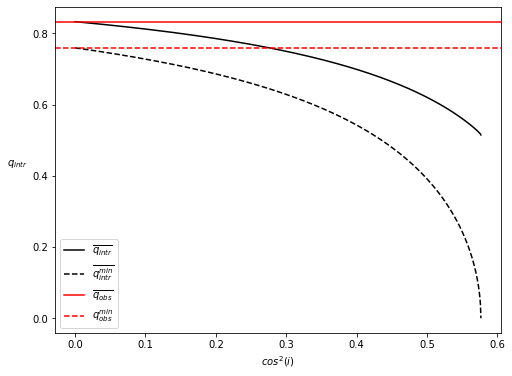

In [23]:
plt.figure(figsize=(8,6))
#plt.plot(180/np.pi*np.arccos(np.sqrt(xx)), yy, c='k', label=r'$\overline{q_{intr}}$')
#plt.plot(180/np.pi*np.arccos(np.sqrt(xx)), qintr_min, c='k', linestyle='--', label=r'$\overline{q_{intr}^{min}}$')
plt.plot(xx, yy, c='k', label=r'$\overline{q_{intr}}$')
plt.plot(xx, qintr_min, c='k', linestyle='--', label=r'$\overline{q_{intr}^{min}}$')
plt.axhline(np.sum(qobs*weights), c='r', linestyle='-', label=r'$\overline{q_{obs}}$')
plt.axhline(np.min(qobs), c='r', linestyle='--', label=r'$q_{obs}^{min}$')
#plt.xlabel(r'i [deg]')
plt.xlabel(r'$cos^2(i)$')
plt.ylabel(r'$q_{intr}$', rotation=0, ha='right')
plt.legend()

In [25]:
q_intr_bound_lo = np.sum( np.sqrt( (qobs**2 - np.min(qobs)**2)/(1 - np.min(qobs)**2) ) * weights)
q_intr_bound_hi = np.sum( qobs * weights )

q_intrs = np.linspace(q_intr_bound_lo, q_intr_bound_hi, 1000)

inclinations = np.zeros(1000)

for i, q in enumerate(q_intrs):
    
    f = lambda x: np.sum( np.sqrt( (qobs**2 - x)/(1 - x) ) * weights) - q
    
    xx = fsolve(f, 0.9999*np.min(qobs)**2)
    #inc = 180/np.pi*np.arccos(np.sqrt(xx))
    inclinations[i] = xx
    #inclinations[i] = inc

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


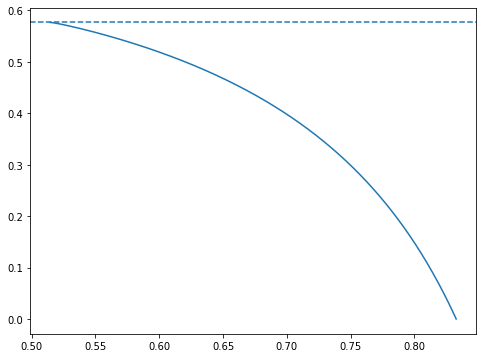

In [26]:
plt.figure(figsize=(8,6))
plt.plot(q_intrs, inclinations)
plt.axhline(np.min(qobs)**2, linestyle='--')

# Okay let's put this together.

In [27]:
weights

array([0.04154785, 0.03544701, 0.06569691, 0.11704491, 0.13558019,
       0.1791138 , 0.42556932])

In [28]:
def calculate_inclination_and_q_intr_bounds (surf_lum, sigma_lum, qobs_lum):
    
    qobs=qobs_lum
    
    # weights from luminosities of MGEs
    lums = 2 * np.pi * surf_lum * sigma_lum**2 * qobs
    weights = lums / np.sum(lums)
    
    # get bounds for calculation from 2D MGEs
    x_bound_lo = 0
    x_bound_hi = np.min(qobs)**2
    q_intr_bound_lo = np.sum( np.sqrt( (qobs**2 - np.min(qobs)**2)/(1 - np.min(qobs)**2) ) * weights)
    q_intr_bound_hi = np.sum( qobs * weights )
    
    return x_bound_lo, x_bound_hi, q_intr_bound_lo, q_intr_bound_hi

def calculate_inclination_from_q_intr (bounds, qobs, q_intr):
    
    x_bound_lo, x_bound_hi, q_intr_bound_lo, q_intr_bound_hi = bounds
    
    f = lambda x: np.sum( np.sqrt( (qobs**2 - x)/(1 - x) ) * weights) - q_intr
    
    xx = fsolve(f, 0.9999*x_bound_hi)[0]
    
    inclination = 180/np.pi*np.arccos(np.sqrt(xx))
    
    return inclination

In [29]:
bounds =  np.array(calculate_inclination_and_q_intr_bounds (surf, sigma, qobs))
calculate_inclination_from_q_intr(bounds, qobs, 0.4)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


40.60584106539364

In [30]:
#if fast_slow == 'fast':
        #        # make the prior a gaussian from Weijman 2014
        #        p0[1] = 0.25
        #        sigpar[1] = 0.14
        #        prior_type[1]='gaussian'
        #    elif fast_slow == 'slow':
        #        # make the prior a gaussian from Li 2018
        #        p0[1] = 0.74
        #        sigpar[1] = 0.08
        #        prior_type[1]='gaussian'  
        #        # bound it lower by q_intr > 0.6
        #        bounds[0][1] = 0.6

In [31]:
import scipy.stats as stats

In [32]:
#q_intrs = np.random.normal(0.74, 0.08, 1000)
#inclinations = np.zeros(1000)

bounds =  np.array(calculate_inclination_and_q_intr_bounds (surf, sigma, qobs))

lower, upper = bounds[2], bounds[3]
mu, sig = 0.74, 0.08
X = stats.truncnorm(
    (lower - mu) / sig, (upper - mu) / sig, loc=mu, scale=sig)
q_intrs = X.rvs(1000)

for i, q_intr in enumerate(q_intrs):
    
    inclination = calculate_inclination_from_q_intr(bounds, qobs, q_intr)
    inclinations[i] = inclination
    


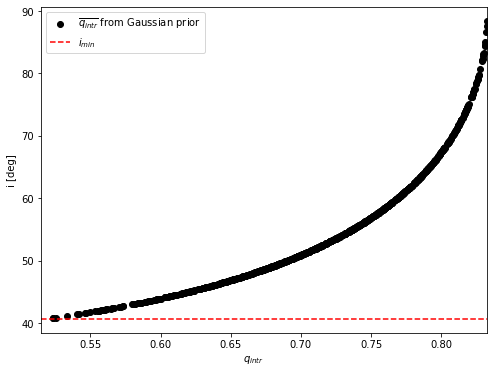

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(q_intrs, inclinations, c='k', label=r'$\overline{q_{intr}}$ from Gaussian prior')
plt.axhline(180/np.pi*np.arccos(np.sqrt(bounds[1])), c='r', linestyle='--', label=r'$i_{min}$')
#plt.axvline(np.min(qobs), color='k', c='r', linestyle='--', label=r'$q_{obs}^{min}$')
plt.xlim(bounds[2], bounds[3])
plt.ylabel(r'i [deg]')
#plt.xlabel(r'$cos^2(i)$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.legend(loc='upper left')

In [34]:
bounds

array([0.        , 0.57644982, 0.51464915, 0.8327698 ])

(0.5146491471294484, 0.832769801977757)

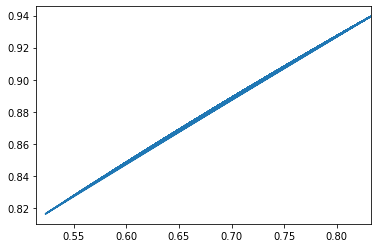

In [35]:
Rs = np.sqrt(0.3+0.7*q_intrs)

plt.plot(q_intrs, Rs)
plt.xlim(bounds[2],bounds[3])


In [36]:
ks = np.random.uniform(0, 1, 1000)

In [37]:
ratios = Rs + (1 - Rs) * ks

In [38]:
qs_line = np.linspace(bounds[2], bounds[3], 1000)
Rs_line = np.sqrt(0.3 + 0.7 * qs_line)

Text(0.5, 1.0, 'JAM$_{axi}^{cyl}$')

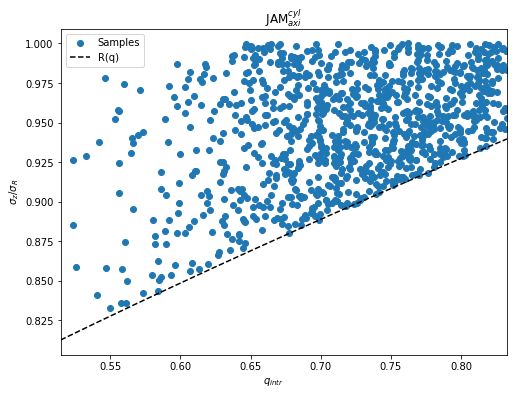

In [39]:
plt.figure(figsize=(8,6))
plt.scatter(q_intrs, ratios, label='Samples')
plt.plot(qs_line, Rs_line, c='k', markersize=1, label='R(q)', linestyle='--')
plt.ylabel(r'$\sigma_{z}/\sigma_R$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.xlim(bounds[2],bounds[3])
plt.legend()
plt.title(r'JAM$_{axi}^{cyl}$')

Text(0.5, 1.0, 'JAM$_{axi}^{sph}$')

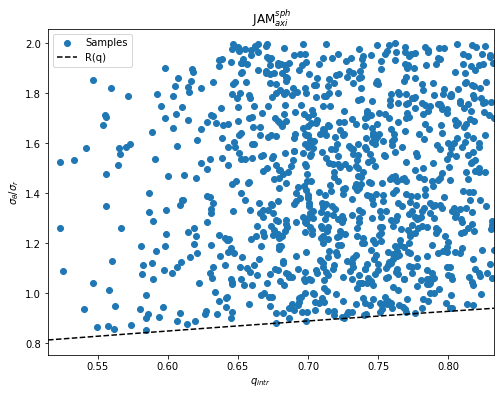

In [40]:
ratios_sph = Rs + (2 - Rs) * ks

plt.figure(figsize=(8,6))
plt.scatter(q_intrs, ratios_sph, label='Samples')
plt.plot(qs_line, Rs_line, c='k', markersize=1, label='R(q)', linestyle='--')
plt.ylabel(r'$\sigma_{\theta}/\sigma_r$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.xlim(bounds[2],bounds[3])
plt.legend()
plt.title(r'JAM$_{axi}^{sph}$')

Text(0.5, 1.0, 'JAM$_{axi}^{cyl}$')

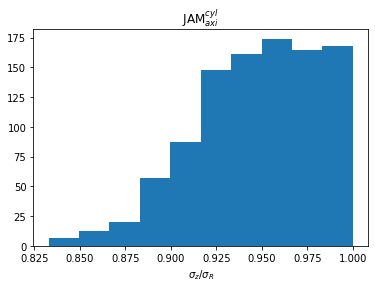

In [41]:
plt.hist(ratios)
plt.xlabel(r'$\sigma_{z}/\sigma_R$')

plt.title(r'JAM$_{axi}^{cyl}$')

Text(0.5, 1.0, 'JAM$_{axi}^{sph}$')

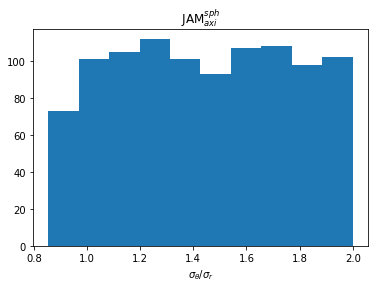

In [42]:
plt.hist(ratios_sph)
plt.xlabel(r'$\sigma_{\theta}/\sigma_r$')
plt.title(r'JAM$_{axi}^{sph}$')

___________________________

# Question: Michele has taken the intrinsic shape within the effective radius. Do I need to change the way I calculate the intrinsic shape, since I am using MGEs that extend well past that?

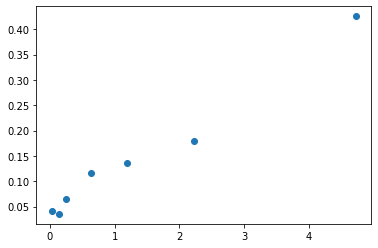

In [45]:
plt.scatter(sigma, weights)

In [46]:
# Dammit

In [49]:
help(mge_half_light_isophote)#(surf, sigma, qobs)

Help on function mge_half_light_isophote in module jampy.mge_half_light_isophote:

mge_half_light_isophote(surf, sigma, q_obs, distance=1e-05)
    PURPOSE
    -------
    
        Computes the half-light radius, the  major axis and ellipticity of
        the MGE isophote containing 1/2 of the analytic MGE total light.
    
        This procedure implements the steps (i)-(iv) described above
        equation (12) in `Cappellari et al. (2013, MNRAS, 432, 1709)
        <https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C>`_
    
    CALLING SEQUENCE
    ----------------
    
    .. code-block:: python
    
        from jampy.mge_half_light_isophote import mge_half_light_isophote
    
        reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(
                surf, sigma, q_obs, distance=distance)
    
    INPUT PARAMETERS
    ----------------
    
    surf:
        Peak surface brightness of each Gaussian in Lsun/pc**2
    sigma:
        Gaussian dispersion in arcsec
    q_obs: 
 

In [51]:
reff, reff_maj, eps, lum_tot = mge_half_light_isophote(surf, sigma, qobs)

In [52]:
1-eps

0.8329137611066642

In [53]:
q_intr_bound_hi

0.832769801977757

In [59]:
# Well actually that is ludicrously close to what I have... What about the other galaxies

In [71]:
surf = kwargs_list[3]['surf_lum']
sigma = kwargs_list[3]['sigma_lum']
qobs = kwargs_list[3]['qobs_lum']

In [72]:
reff, reff_maj, eps, lum_tot = mge_half_light_isophote(surf, sigma, qobs)
1-eps


0.7031865187979719

In [73]:
calculate_inclination_and_q_intr_bounds(surf,sigma,qobs)

(0, 0.48999999999999994, 0.2576772523593839, 0.7475133376752084)

In [74]:
surf = kwargs_list[6]['surf_lum']
sigma = kwargs_list[6]['sigma_lum']
qobs = kwargs_list[6]['qobs_lum']

In [75]:
reff, reff_maj, eps, lum_tot = mge_half_light_isophote(surf, sigma, qobs)
1-eps


0.7509448604381085

In [76]:
calculate_inclination_and_q_intr_bounds(surf,sigma,qobs)

(0, 0.5625, 0.03847716511503177, 0.7516122915638724)

# Okay, what if I deproject the MGEs, reproject to a different inclination, and then try to measure the observed effective ellipticity again?

In [85]:
x = 0.1
q_intr = np.sqrt( (qobs**2 -x)/(1 - x) )
print(q_intr)

[0.71686044 0.71686044 0.71686044 0.71686044 0.71686044 0.71686044
 0.72388065 0.71686044]


In [86]:
x_new = 0.6

q_obs_new = np.sqrt( q_intr**2 * (1 - x_new) + x_new )

In [87]:
q_obs_new

array([0.89752747, 0.89752747, 0.89752747, 0.89752747, 0.89752747,
       0.89752747, 0.89977846, 0.89752747])

In [88]:
reff, reff_maj, eps, lum_tot = mge_half_light_isophote(surf, sigma, q_obs_new)
1-eps


0.897714510679562

In [89]:
reff, reff_maj, eps, lum_tot = mge_half_light_isophote(surf, sigma, q_intr)
1-eps


0.7177901052453944

In [144]:
q_intr_proposed = 0.7177901052453944

reff, reff_maj, eps, lum_tot = mge_half_light_isophote(surf, sigma, qobs)
q_obs_eff = 1-eps


f = lambda x: np.sqrt( (q_obs_eff**2 -x)/(1 - x) ) - q_intr_proposed
    
xx = fsolve(f, 0.5)[0]

q_intrs = np.sqrt( (qobs**2 - xx)/(1 - xx))

reff, reff_maj, eps, lum_tot = mge_half_light_isophote(surf, sigma, q_intrs)
1-eps

0.7177168692227726

In [96]:
print(xx)

0.1004493026383767


In [98]:
print(180/np.pi * np.sqrt(np.arccos(xx)))

69.47163069940575


In [95]:
# Okay, I see, the effective intrinsic shape is the shape of the isophote that would contain half the total light when viewed edge-on.

In [99]:
q_intrs

array([0.71669107, 0.71669107, 0.71669107, 0.71669107, 0.71669107,
       0.71669107, 0.72371641, 0.71669107])

In [115]:
# Getting lower bound on q_intr_eff is where x = qobs_min**2

def get_bounds_x_and_q_intr_eff (surf, sigma, qobs):
    
    x_bound_hi = 0.9999999*np.min(qobs)**2
    x_bound_lo = 0
    
    # intrinsic shape bounds
    reff, reff_maj, eps, lum_tot = mge_half_light_isophote(surf, sigma, qobs)
    q_intr_eff_bound_hi = 1-eps
    q_intrs_bound_lo = np.sqrt( (qobs**2 - x_bound_hi)/(1 - x_bound_hi))
    reff, reff_maj, eps, lum_tot = mge_half_light_isophote(surf, sigma, q_intrs_bound_lo)
    q_intr_eff_bound_lo = 1-eps
    
    return x_bound_lo, x_bound_hi, q_intr_eff_bound_lo, q_intr_eff_bound_hi

get_bounds_x_and_q_intr_eff(surf, sigma, qobs)

(0, 0.56249994375, 0.14451703237812485, 0.7509448604381085)

In [116]:
calculate_inclination_and_q_intr_bounds(surf, sigma, qobs)

(0, 0.5625, 0.03847716511503177, 0.7516122915638724)

# Okay, this can work.

In [145]:
def calculate_inclination_from_q_intr_eff (bounds, surf, sigma, qobs, q_intr):
    
    reff, reff_maj, eps, lum_tot = mge_half_light_isophote(surf, sigma, qobs)
    q_obs_eff = 1-eps

    f = lambda x: np.sqrt( (q_obs_eff**2 -x)/(1 - x) ) - q_intr
    
    xx = fsolve(f, 0.999999*bounds[1])[0]

    #q_intrs = np.sqrt( (qobs**2 - xx)/(1 - xx))

    #reff, reff_maj, eps, lum_tot = mge_half_light_isophote(surf, sigma, q_intrs)
    #1-eps
    
    inclination = 180/np.pi*np.arccos(np.sqrt(xx))
    
    return inclination

# Use J0029

In [414]:
surf = kwargs_list[0]['surf_lum']
sigma = kwargs_list[0]['sigma_lum']
qobs = kwargs_list[0]['qobs_lum']

bounds = get_bounds_x_and_q_intr_eff(surf, sigma, qobs)
calculate_inclination_from_q_intr_eff(bounds, surf, sigma, qobs, q_intr_proposed)

52.63850010454453

In [415]:
inclinations_eff = np.zeros(1000)
inclinations_avg = np.zeros(1000)

In [416]:
bounds_eff = get_bounds_x_and_q_intr_eff(surf, sigma, qobs)
bounds_avg =  calculate_inclination_and_q_intr_bounds (surf, sigma, qobs)

In [417]:
print(bounds_eff, bounds_avg)

(0, 0.5764497581337367, 0.530387721172158, 0.8329137611066642) (0, 0.5764498157787182, 0.5146491471294484, 0.832769801977757)


In [418]:
q_intrs = np.linspace(bounds_eff[2], bounds_eff[3], 1000)

for i, q_intr in enumerate(q_intrs):
    
    inclination_eff = calculate_inclination_from_q_intr_eff(bounds_eff, surf, sigma, qobs, q_intr)
    inclinations_eff[i] = inclination_eff
    
    inclination_avg = calculate_inclination_from_q_intr(bounds_avg, qobs, q_intr)
    inclinations_avg[i] = inclination_avg

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


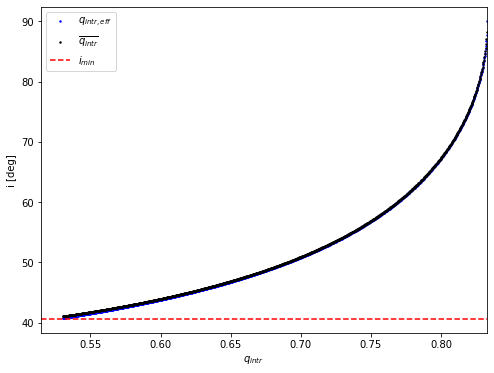

In [419]:
plt.figure(figsize=(8,6))
plt.scatter(q_intrs, inclinations_eff, c='b', s=2, label=r'${q_{intr,eff}}$')
plt.scatter(q_intrs, inclinations_avg, c='k', s=2, label=r'$\overline{q_{intr}}$')
plt.axhline(180/np.pi*np.arccos(np.sqrt(bounds_eff[1])), c='r', linestyle='--', label=r'$i_{min}$')
#plt.axvline(np.min(qobs), color='k', c='r', linestyle='--', label=r'$q_{obs}^{min}$')
xlim_lo = np.min([bounds_eff[2], bounds_avg[2]])
xlim_hi=np.max([bounds_avg[3], bounds_eff[3]])
plt.xlim(xlim_lo, xlim_hi)
plt.ylabel(r'i [deg]')
#plt.xlabel(r'$cos^2(i)$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.legend(loc='upper left')

(58.154452247498504, 90.0)

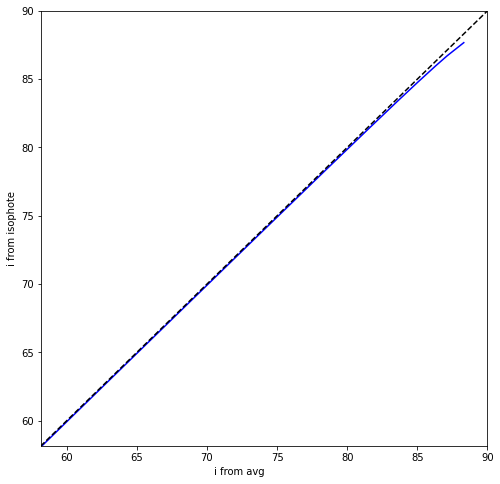

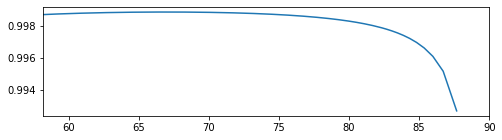

In [420]:
plt.figure(figsize=(8,8))
plt.plot(inclinations_avg, inclinations_eff, c='b')
plt.plot(np.linspace(0, 90, 1000), np.linspace(0, 90, 1000), c='k', linestyle='--')

#plt.scatter(q_intrs, inclinations_avg, c='k', label=r'$\overline{q_{intr}}$ from Gaussian prior')
#plt.axhline(180/np.pi*np.arccos(np.sqrt(bounds[1])), c='r', linestyle='--', label=r'$i_{min}$')
#plt.axvline(np.min(qobs), color='k', c='r', linestyle='--', label=r'$q_{obs}^{min}$')
plt.xlim(180/np.pi*np.sqrt(np.arccos(xlim_lo)), 90)
plt.ylim(180/np.pi*np.sqrt(np.arccos(xlim_lo)), 90)
plt.ylabel(r'i from isophote')
#plt.xlabel(r'$cos^2(i)$')
plt.xlabel(r'i from avg', rotation=0, ha='right')
#plt.legend(loc='upper left')

plt.figure(figsize=(8,2))
plt.plot(inclinations_eff, inclinations_eff/inclinations_avg)
plt.xlim(180/np.pi*np.sqrt(np.arccos(xlim_lo)), 90)

In [422]:
lower, upper = bounds_eff[2], bounds_eff[3]
mu, sig = 0.74, 0.08
X = stats.truncnorm(
    (lower - mu) / sig, (upper - mu) / sig, loc=mu, scale=sig)
q_intrs = X.rvs(1000)

for i, q_intr in enumerate(q_intrs):
    
    inclination_eff = calculate_inclination_from_q_intr_eff(bounds, surf, sigma, qobs, q_intr)
    inclinations_eff[i] = inclination_eff
    
    inclination_avg = calculate_inclination_from_q_intr(bounds, qobs, q_intr)
    inclinations_avg[i] = inclination_avg
    

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


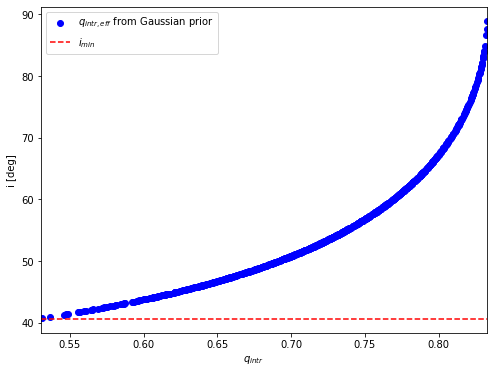

In [423]:
plt.figure(figsize=(8,6))
plt.scatter(q_intrs, inclinations_eff, c='b', label=r'${q_{intr,eff}}$ from Gaussian prior')
#plt.scatter(q_intrs, inclinations_avg, c='k', label=r'$\overline{q_{intr}}$ from Gaussian prior')
plt.axhline(180/np.pi*np.arccos(np.sqrt(bounds[1])), c='r', linestyle='--', label=r'$i_{min}$')
#plt.axvline(np.min(qobs), color='k', c='r', linestyle='--', label=r'$q_{obs}^{min}$')
plt.xlim(bounds[2], bounds[3])
plt.ylabel(r'i [deg]')
#plt.xlabel(r'$cos^2(i)$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.legend(loc='upper left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


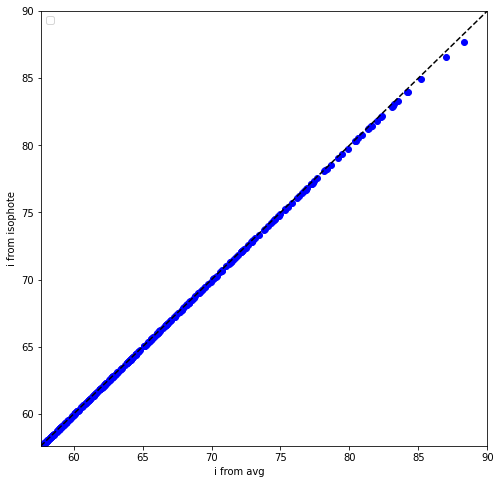

In [424]:
plt.figure(figsize=(8,8))
plt.scatter(inclinations_avg, inclinations_eff, c='b')
plt.plot(np.linspace(0, 90, 1000), np.linspace(0, 90, 1000), c='k', linestyle='--')

#plt.scatter(q_intrs, inclinations_avg, c='k', label=r'$\overline{q_{intr}}$ from Gaussian prior')
#plt.axhline(180/np.pi*np.arccos(np.sqrt(bounds[1])), c='r', linestyle='--', label=r'$i_{min}$')
#plt.axvline(np.min(qobs), color='k', c='r', linestyle='--', label=r'$q_{obs}^{min}$')
plt.xlim(180/np.pi*np.sqrt(np.arccos(lower)), 90)
plt.ylim(180/np.pi*np.sqrt(np.arccos(lower)), 90)
plt.ylabel(r'i from isophote')
#plt.xlabel(r'$cos^2(i)$')
plt.xlabel(r'i from avg', rotation=0, ha='right')
plt.legend(loc='upper left')

(0.530387721172158, 0.8329137611066642)

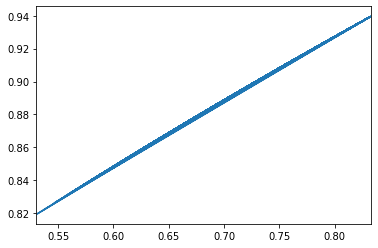

In [425]:
Rs = np.sqrt(0.3+0.7*q_intrs)

plt.plot(q_intrs, Rs)
plt.xlim(bounds[2],bounds[3])


In [404]:
ks = np.random.uniform(0, 1, 1000)

In [405]:
ratios = Rs + (1 - Rs) * ks

In [406]:
qs_line = np.linspace(bounds[2], bounds[3], 1000)
Rs_line = np.sqrt(0.3 + 0.7 * qs_line)

Text(0.5, 1.0, 'JAM$_{axi}^{cyl}$')

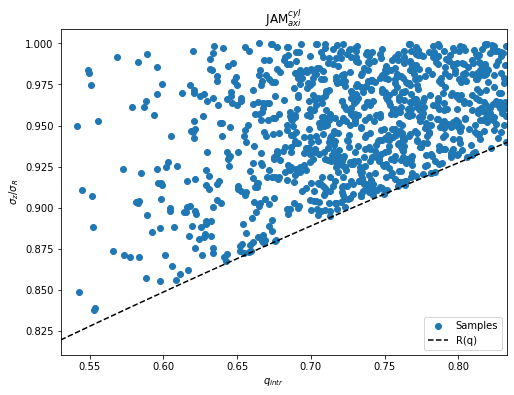

In [407]:
plt.figure(figsize=(8,6))
plt.scatter(q_intrs, ratios, label='Samples')
plt.plot(qs_line, Rs_line, c='k', markersize=1, label='R(q)', linestyle='--')
plt.ylabel(r'$\sigma_{z}/\sigma_R$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.xlim(bounds[2],bounds[3])
plt.legend()
plt.title(r'JAM$_{axi}^{cyl}$')

Text(0.5, 1.0, 'JAM$_{axi}^{sph}$')

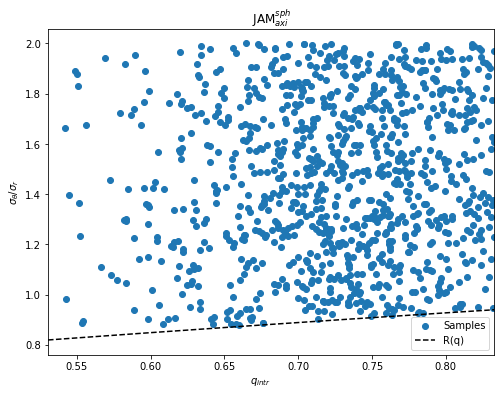

In [408]:
ratios_sph = Rs + (2 - Rs) * ks

plt.figure(figsize=(8,6))
plt.scatter(q_intrs, ratios_sph, label='Samples')
plt.plot(qs_line, Rs_line, c='k', markersize=1, label='R(q)', linestyle='--')
plt.ylabel(r'$\sigma_{\theta}/\sigma_r$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.xlim(bounds[2],bounds[3])
plt.legend()
plt.title(r'JAM$_{axi}^{sph}$')

Text(0.5, 1.0, 'JAM$_{axi}^{cyl}$')

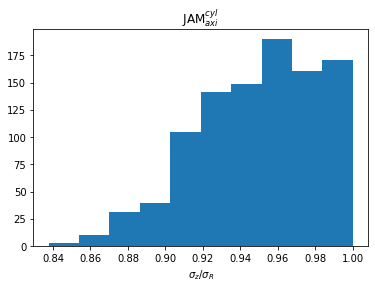

In [409]:
plt.hist(ratios)
plt.xlabel(r'$\sigma_{z}/\sigma_R$')

plt.title(r'JAM$_{axi}^{cyl}$')

Text(0.5, 1.0, 'JAM$_{axi}^{sph}$')

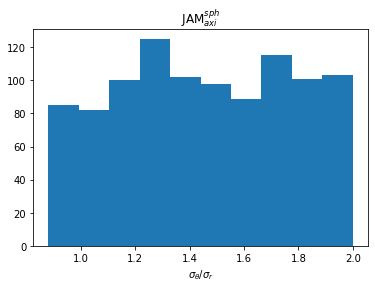

In [410]:
plt.hist(ratios_sph)
plt.xlabel(r'$\sigma_{\theta}/\sigma_r$')
plt.title(r'JAM$_{axi}^{sph}$')

# Now J0037

In [426]:
surf = kwargs_list[3]['surf_lum']
sigma = kwargs_list[3]['sigma_lum']
qobs = kwargs_list[3]['qobs_lum']

bounds = get_bounds_x_and_q_intr_eff(surf, sigma, qobs)
calculate_inclination_from_q_intr_eff(bounds, surf, sigma, qobs, 0.6)

62.71743853411902

In [427]:
inclinations_eff = np.zeros(1000)


In [428]:
bounds_eff = get_bounds_x_and_q_intr_eff(surf, sigma, qobs)


In [429]:
print(bounds_eff)

(0, 0.489999951, 0.5421162889348848, 0.7031865187979719)


In [430]:
q_intrs = np.linspace(lower, upper, 1000)

for i, q_intr in enumerate(q_intrs):
    
    inclination_eff = calculate_inclination_from_q_intr_eff(bounds_eff, surf, sigma, qobs, q_intr)
    inclinations_eff[i] = inclination_eff
    
    

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


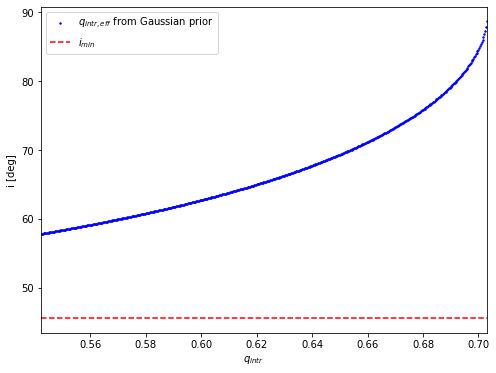

In [431]:
plt.figure(figsize=(8,6))
plt.scatter(q_intrs, inclinations_eff, c='b', s=2, label=r'${q_{intr,eff}}$ from Gaussian prior')
#plt.scatter(q_intrs, inclinations_avg, c='k', s=2, label=r'$\overline{q_{intr}}$ from Gaussian prior')
plt.axhline(180/np.pi*np.arccos(np.sqrt(bounds_eff[1])), c='r', linestyle='--', label=r'$i_{min}$')
#plt.axvline(np.min(qobs), color='k', c='r', linestyle='--', label=r'$q_{obs}^{min}$')
xlim_lo = bounds_eff[2]#np.min([bounds_eff[2], bounds_avg[2]])
xlim_hi=bounds_eff[3]#np.max([bounds_avg[3], bounds_eff[3]])
plt.xlim(xlim_lo, xlim_hi)
plt.ylabel(r'i [deg]')
#plt.xlabel(r'$cos^2(i)$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.legend(loc='upper left')

In [432]:
lower, upper = bounds_eff[2], bounds_eff[3]
mu, sig = 0.74, 0.08
X = stats.truncnorm(
    (lower - mu) / sig, (upper - mu) / sig, loc=mu, scale=sig)
q_intrs = X.rvs(1000)

for i, q_intr in enumerate(q_intrs):
    
    inclination_eff = calculate_inclination_from_q_intr_eff(bounds, surf, sigma, qobs, q_intr)
    inclinations_eff[i] = inclination_eff
    

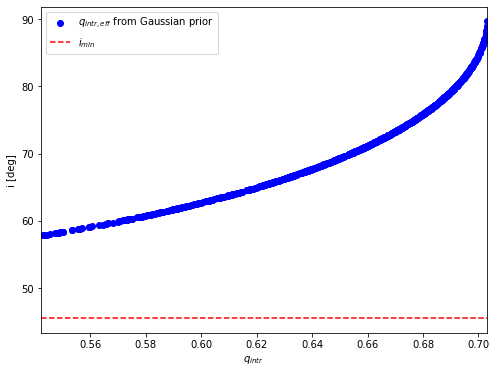

In [433]:
plt.figure(figsize=(8,6))
plt.scatter(q_intrs, inclinations_eff, c='b', label=r'${q_{intr,eff}}$ from Gaussian prior')
plt.axhline(180/np.pi*np.arccos(np.sqrt(bounds[1])), c='r', linestyle='--', label=r'$i_{min}$')
#plt.axvline(np.min(qobs), color='k', c='r', linestyle='--', label=r'$q_{obs}^{min}$')
plt.xlim(bounds[2], bounds[3])
plt.ylabel(r'i [deg]')
#plt.xlabel(r'$cos^2(i)$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.legend(loc='upper left')

(0.5421162889348848, 0.7031865187979719)

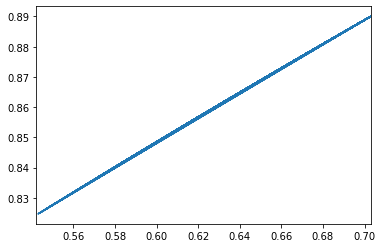

In [434]:
Rs = np.sqrt(0.3+0.7*q_intrs)

plt.plot(q_intrs, Rs)
plt.xlim(bounds[2],bounds[3])

In [435]:
ks = np.random.uniform(0, 1, 1000)

In [436]:
ratios = Rs + (1 - Rs) * ks

In [437]:
qs_line = np.linspace(bounds[2], bounds[3], 1000)
Rs_line = np.sqrt(0.3 + 0.7 * qs_line)

Text(0.5, 1.0, 'JAM$_{axi}^{cyl}$')

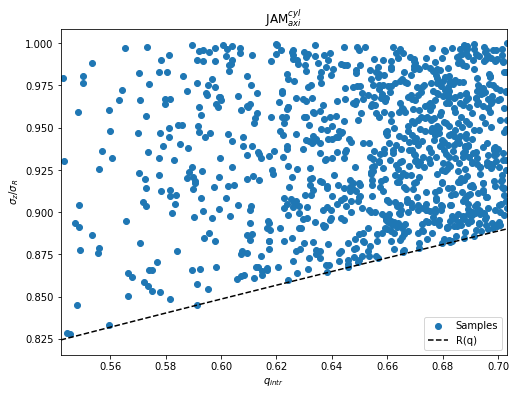

In [438]:
plt.figure(figsize=(8,6))
plt.scatter(q_intrs, ratios, label='Samples')
plt.plot(qs_line, Rs_line, c='k', markersize=1, label='R(q)', linestyle='--')
plt.ylabel(r'$\sigma_{z}/\sigma_R$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.xlim(bounds[2],bounds[3])
plt.legend()
plt.title(r'JAM$_{axi}^{cyl}$')

Text(0.5, 1.0, 'JAM$_{axi}^{sph}$')

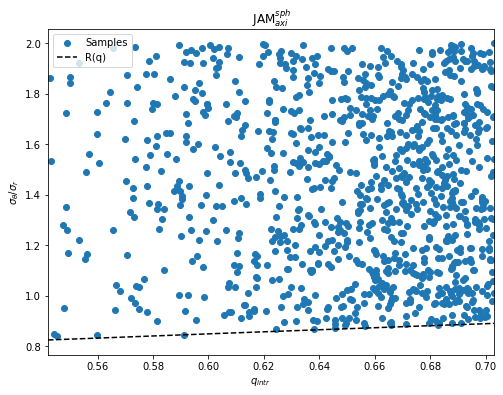

In [439]:
ratios_sph = Rs + (2 - Rs) * ks

plt.figure(figsize=(8,6))
plt.scatter(q_intrs, ratios_sph, label='Samples')
plt.plot(qs_line, Rs_line, c='k', markersize=1, label='R(q)', linestyle='--')
plt.ylabel(r'$\sigma_{\theta}/\sigma_r$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.xlim(bounds[2],bounds[3])
plt.legend()
plt.title(r'JAM$_{axi}^{sph}$')

Text(0.5, 1.0, 'JAM$_{axi}^{cyl}$')

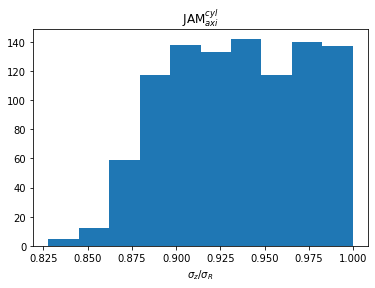

In [440]:
plt.hist(ratios)
plt.xlabel(r'$\sigma_{z}/\sigma_R$')

plt.title(r'JAM$_{axi}^{cyl}$')

Text(0.5, 1.0, 'JAM$_{axi}^{sph}$')

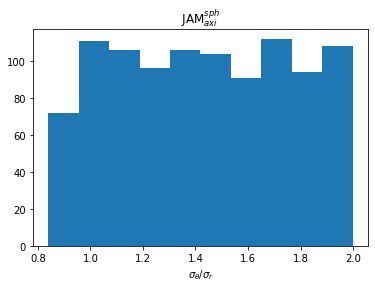

In [441]:
plt.hist(ratios_sph)
plt.xlabel(r'$\sigma_{\theta}/\sigma_r$')
plt.title(r'JAM$_{axi}^{sph}$')

# Now J1112

In [351]:
surf = kwargs_list[7]['surf_lum']
sigma = kwargs_list[7]['sigma_lum']
qobs = kwargs_list[7]['qobs_lum']

bounds = get_bounds_x_and_q_intr_eff(surf, sigma, qobs)
calculate_inclination_from_q_intr_eff(bounds, surf, sigma, qobs, 0.6)

55.63476416322501

In [352]:
inclinations_eff = np.zeros(1000)


In [353]:
bounds_eff = get_bounds_x_and_q_intr_eff(surf, sigma, qobs)


In [354]:
print(bounds_eff)

(0, 0.56249994375, 0.14451703237812485, 0.7509448604381085)


In [355]:
q_intrs = np.linspace(lower, upper, 1000)

for i, q_intr in enumerate(q_intrs):
    
    inclination_eff = calculate_inclination_from_q_intr_eff(bounds_eff, surf, sigma, qobs, q_intr)
    inclinations_eff[i] = inclination_eff
    
    

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


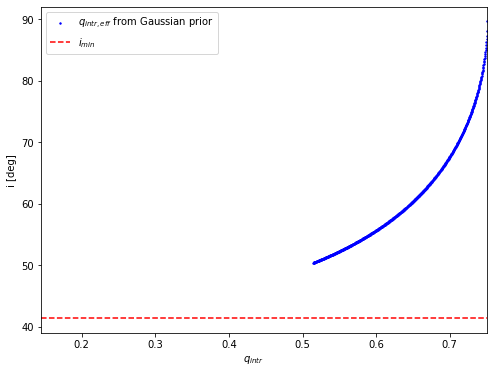

In [356]:
plt.figure(figsize=(8,6))
plt.scatter(q_intrs, inclinations_eff, c='b', s=2, label=r'${q_{intr,eff}}$ from Gaussian prior')
#plt.scatter(q_intrs, inclinations_avg, c='k', s=2, label=r'$\overline{q_{intr}}$ from Gaussian prior')
plt.axhline(180/np.pi*np.arccos(np.sqrt(bounds_eff[1])), c='r', linestyle='--', label=r'$i_{min}$')
#plt.axvline(np.min(qobs), color='k', c='r', linestyle='--', label=r'$q_{obs}^{min}$')
xlim_lo = bounds_eff[2]#np.min([bounds_eff[2], bounds_avg[2]])
xlim_hi=bounds_eff[3]#np.max([bounds_avg[3], bounds_eff[3]])
plt.xlim(xlim_lo, xlim_hi)
plt.ylabel(r'i [deg]')
#plt.xlabel(r'$cos^2(i)$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.legend(loc='upper left')

In [357]:
lower, upper = bounds[2], bounds[3]
mu, sig = 0.74, 0.08
X = stats.truncnorm(
    (lower - mu) / sig, (upper - mu) / sig, loc=mu, scale=sig)
q_intrs = X.rvs(1000)

for i, q_intr in enumerate(q_intrs):
    
    inclination_eff = calculate_inclination_from_q_intr_eff(bounds, surf, sigma, qobs, q_intr)
    inclinations_eff[i] = inclination_eff
    

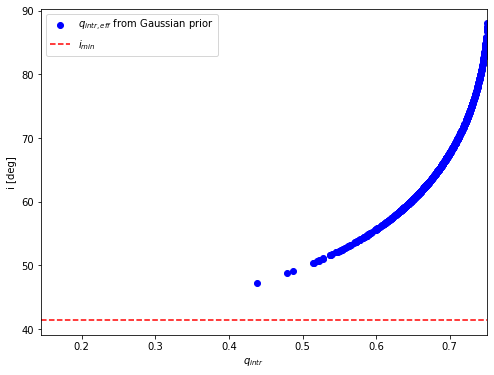

In [358]:
plt.figure(figsize=(8,6))
plt.scatter(q_intrs, inclinations_eff, c='b', label=r'${q_{intr,eff}}$ from Gaussian prior')
plt.axhline(180/np.pi*np.arccos(np.sqrt(bounds[1])), c='r', linestyle='--', label=r'$i_{min}$')
#plt.axvline(np.min(qobs), color='k', c='r', linestyle='--', label=r'$q_{obs}^{min}$')
plt.xlim(bounds[2], bounds[3])
plt.ylabel(r'i [deg]')
#plt.xlabel(r'$cos^2(i)$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.legend(loc='upper left')

(0.14451703237812485, 0.7509448604381085)

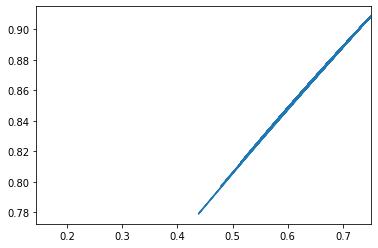

In [359]:
Rs = np.sqrt(0.3+0.7*q_intrs)

plt.plot(q_intrs, Rs)
plt.xlim(bounds[2],bounds[3])

In [360]:
ks = np.random.uniform(0, 1, 1000)

In [361]:
ratios = Rs + (1 - Rs) * ks

In [362]:
qs_line = np.linspace(bounds[2], bounds[3], 1000)
Rs_line = np.sqrt(0.3 + 0.7 * qs_line)

Text(0.5, 1.0, 'JAM$_{axi}^{cyl}$')

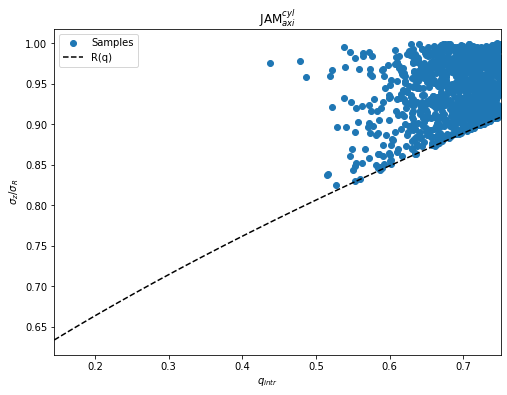

In [363]:
plt.figure(figsize=(8,6))
plt.scatter(q_intrs, ratios, label='Samples')
plt.plot(qs_line, Rs_line, c='k', markersize=1, label='R(q)', linestyle='--')
plt.ylabel(r'$\sigma_{z}/\sigma_R$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.xlim(bounds[2],bounds[3])
plt.legend()
plt.title(r'JAM$_{axi}^{cyl}$')

Text(0.5, 1.0, 'JAM$_{axi}^{sph}$')

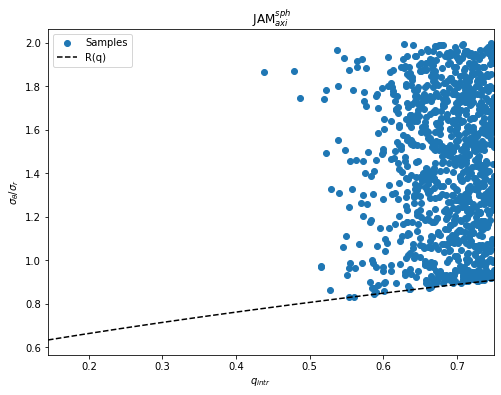

In [364]:
ratios_sph = Rs + (2 - Rs) * ks

plt.figure(figsize=(8,6))
plt.scatter(q_intrs, ratios_sph, label='Samples')
plt.plot(qs_line, Rs_line, c='k', markersize=1, label='R(q)', linestyle='--')
plt.ylabel(r'$\sigma_{\theta}/\sigma_r$')
plt.xlabel(r'$q_{intr}$', rotation=0, ha='right')
plt.xlim(bounds[2],bounds[3])
plt.legend()
plt.title(r'JAM$_{axi}^{sph}$')

Text(0.5, 1.0, 'JAM$_{axi}^{cyl}$')

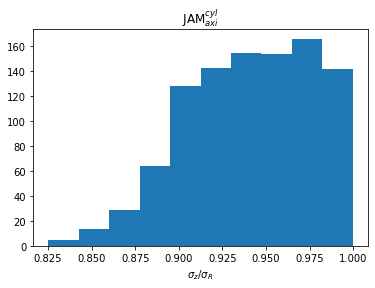

In [365]:
plt.hist(ratios)
plt.xlabel(r'$\sigma_{z}/\sigma_R$')

plt.title(r'JAM$_{axi}^{cyl}$')

Text(0.5, 1.0, 'JAM$_{axi}^{sph}$')

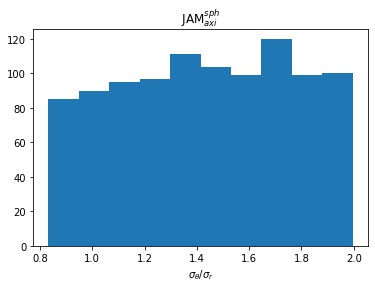

In [366]:
plt.hist(ratios_sph)
plt.xlabel(r'$\sigma_{\theta}/\sigma_r$')
plt.title(r'JAM$_{axi}^{sph}$')

__________________
__________________

# BREAK
__________________
__________________